In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
# Librerías comunes (ejecuta una vez)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import coint
from scipy.stats import zscore
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,5)


Recopilación de los datos de BBVA y Banco Santander de yahoo finances. ddesde el 1 de enero de 2000 hasta la fecha

In [141]:
import yfinance as yf
import pandas as pd
BBVA_ticker = "BBVA.MC" 
SANTANDER_ticker = "SAN.MC"

start_date = "2000-01-01"
end_date = "2025-10-31"   # ✅ 31 de octubre de 2025

# Descargar datos históricos
BBVA_data = yf.download(BBVA_ticker, start=start_date, end=end_date, auto_adjust=False, actions=True)
SANTANDER_data = yf.download(SANTANDER_ticker, start=start_date, end=end_date, auto_adjust=False, actions=True)

print("BBVA Data:")
print(BBVA_data.head())
print("\nSantander Data:")
print(SANTANDER_data.head())

# Guardar CSV individuales (opcional)
BBVA_data.to_csv("bbva.csv")
SANTANDER_data.to_csv("santander.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


BBVA Data:
Price      Adj Close      Close Dividends       High        Low       Open  \
Ticker       BBVA.MC    BBVA.MC   BBVA.MC    BBVA.MC    BBVA.MC    BBVA.MC   
Date                                                                         
2000-01-03  4.040036  13.623349       0.0  13.757854  13.594527  13.690602   
2000-01-04  3.934619  13.267874       0.0  13.536882  13.219837  13.450416   
2000-01-05  3.846296  12.970044       0.0  13.210230  12.912399  13.142977   
2000-01-06  3.846296  12.970044       0.0  12.970044  12.970044  12.970044   
2000-01-07  3.894730  13.133370       0.0  13.248659  12.998866  13.248659   

Price      Stock Splits    Volume  
Ticker          BBVA.MC   BBVA.MC  
Date                               
2000-01-03          0.0   8244257  
2000-01-04          0.0   8522096  
2000-01-05          0.0  12159826  
2000-01-06          0.0         0  
2000-01-07          0.0  62261944  

Santander Data:
Price      Adj Close     Close Dividends      High       Lo

Descarga de macrovariables en un dataset

In [142]:
import pandas_datareader.data as pdr


In [143]:
import pandas as pd
import yfinance as yf
import pandas_datareader.data as pdr

start_date = "2000-01-01"
end_date = "2025-10-31"   # ✅ 31 de octubre de 2025

macro_vars = {
    "FEDFUNDS": "tasa_interes",               
    "CPIAUCSL": "inflacion",                  
    "GDPC1": "PIB",                           
    "UNRATE": "desempleo",                    
    "DEXUSEU": "tipo_cambio",                 
    "M2SL": "liquidez_M2",                    
    "PALLFNFINDEXQ": "materias_primas",       
    "GS10": "politica_monetaria",             
    "BAMLH0A0HYM2": "sentimiento_global"      
}

macro_data = pd.DataFrame()

# Datos FRED (EEUU)
for fred_code, name in macro_vars.items():
    try:
        df = pdr.DataReader(fred_code, 'fred', start_date, end_date)
        df.rename(columns={fred_code: name}, inplace=True)
        macro_data = pd.concat([macro_data, df], axis=1)
    except Exception as e:
        print(f"No se pudo descargar {fred_code}: {e}")

# Datos Eurozona y España desde FRED
euro_vars = {}

try:
    euro_infl = pdr.DataReader('CP0000EZ19M086NEST', 'fred', start_date, end_date)  # Inflación Eurozona
    euro_vars["inflacion_eurozona"] = euro_infl
except Exception as e:
    print(f"No se pudo descargar inflación Eurozona: {e}")

try:
    unemp_spain = pdr.DataReader('LRHUTTTTESM156S', 'fred', start_date, end_date)   # Desempleo España
    euro_vars["desempleo_espana"] = unemp_spain
except Exception as e:
    print(f"No se pudo descargar desempleo España: {e}")

euro_data = pd.concat(euro_vars.values(), axis=1) if euro_vars else pd.DataFrame()
if not euro_data.empty:
    euro_data.columns = euro_vars.keys()

# Descargar VIX
VIX_data = yf.download("^VIX", start=start_date, end=end_date)[["Close"]]
VIX_data.rename(columns={"Close": "VIX"}, inplace=True)

# Unir todo
macro_data = macro_data.resample('D').ffill()
euro_data = euro_data.resample('D').ffill()
VIX_data = VIX_data.resample('D').ffill()

global_macro = macro_data.join([euro_data, VIX_data], how="outer").resample('D').ffill()

print("✅ Dataset combinado creado correctamente.")
print(global_macro.tail())


[*********************100%***********************]  1 of 1 completed

✅ Dataset combinado creado correctamente.
            tasa_interes  inflacion  PIB  desempleo  tipo_cambio  liquidez_M2  \
2025-10-27           NaN        NaN  NaN        NaN       1.1636          NaN   
2025-10-28           NaN        NaN  NaN        NaN       1.1659          NaN   
2025-10-29           NaN        NaN  NaN        NaN       1.1664          NaN   
2025-10-30           NaN        NaN  NaN        NaN       1.1564          NaN   
2025-10-31           NaN        NaN  NaN        NaN       1.1541          NaN   

            materias_primas  politica_monetaria  sentimiento_global  \
2025-10-27              NaN                 NaN                2.80   
2025-10-28              NaN                 NaN                2.82   
2025-10-29              NaN                 NaN                2.76   
2025-10-30              NaN                 NaN                2.85   
2025-10-31              NaN                 NaN                2.94   

            inflacion_eurozona  desempleo_es

Combinar macrovariables con el dataset de BBVA 



In [144]:
# Aplanar las columnas
BBVA_data.columns = ['_'.join(col).strip() for col in BBVA_data.columns.values]

# Verificar resultado
print(BBVA_data.head())
print(BBVA_data.columns)


            Adj Close_BBVA.MC  Close_BBVA.MC  Dividends_BBVA.MC  High_BBVA.MC  \
Date                                                                            
2000-01-03           4.040036      13.623349                0.0     13.757854   
2000-01-04           3.934619      13.267874                0.0     13.536882   
2000-01-05           3.846296      12.970044                0.0     13.210230   
2000-01-06           3.846296      12.970044                0.0     12.970044   
2000-01-07           3.894730      13.133370                0.0     13.248659   

            Low_BBVA.MC  Open_BBVA.MC  Stock Splits_BBVA.MC  Volume_BBVA.MC  
Date                                                                         
2000-01-03    13.594527     13.690602                   0.0         8244257  
2000-01-04    13.219837     13.450416                   0.0         8522096  
2000-01-05    12.912399     13.142977                   0.0        12159826  
2000-01-06    12.970044     12.970044     

In [145]:
bbva_full = BBVA_data.join(global_macro, how='left').ffill().dropna()
bbva_full.to_csv("bbva_completo.csv")

Combinar las macrovariables con el dataset de Santander 

In [146]:
# Aplanar columnas multinivel (por ejemplo ('Price', 'Close', 'SAN.MC') → 'Price_Close_SAN.MC')
SANTANDER_data.columns = ['_'.join(col).strip() for col in SANTANDER_data.columns.values]

# Hacer el join con los datos macro
santander_full = SANTANDER_data.join(global_macro, how='left').ffill().dropna()

# Guardar el CSV
santander_full.to_csv("santander_completo.csv")

print("✅ Archivo santander_completo.csv guardado correctamente.")


✅ Archivo santander_completo.csv guardado correctamente.


In [147]:
print("\n✅ Dataset BBVA listo:")
print(bbva_full.head())

print("\n✅ Dataset Santander listo:")
print(santander_full.head())

print("\nColumnas del dataset final:")
print(list(bbva_full.columns))


✅ Dataset BBVA listo:
            Adj Close_BBVA.MC  Close_BBVA.MC  Dividends_BBVA.MC  High_BBVA.MC  \
Date                                                                            
2003-01-01           2.819043       8.761985                0.0      8.761985   
2003-01-02           2.967412       9.223142                0.0      9.223142   
2003-01-03           2.948866       9.165497                0.0      9.386468   
2003-01-06           2.948866       9.165497                0.0      9.165497   
2003-01-07           2.998323       9.319216                0.0      9.511365   

            Low_BBVA.MC  Open_BBVA.MC  Stock Splits_BBVA.MC  Volume_BBVA.MC  \
Date                                                                          
2003-01-01     8.761985      8.761985                   0.0               0   
2003-01-02     8.761985      9.223142                   0.0        39035426   
2003-01-03     9.136675      9.165497                   0.0        61596325   
2003-01-06    

## Análisis de series financieras

#### 0.Preparación y variables útiles

In [148]:
# Suponemos bbva_full y santander_full ya cargados (index datetime)
# También global_macro ya existe (VIX, inflacion_eurozona, desempleo_espana, etc.)

# Asegurar frecuencia diaria y alineación
bbva = bbva_full.copy().asfreq('D').ffill()
san = santander_full.copy().asfreq('D').ffill()
macro = global_macro.copy().asfreq('D').ffill()

# Crear precios y retornos logaritmicos
bbva['log_close'] = np.log(bbva['Close_BBVA.MC'])
san['log_close']  = np.log(san['Close_SAN.MC'])

bbva['ret'] = bbva['log_close'].diff()
san['ret']  = san['log_close'].diff()

# Volatilidad rolling (sd of returns)
window_vol = 21  # 1 mes aprox de trading
bbva['vol_roll'] = bbva['ret'].rolling(window_vol).std() * np.sqrt(252)
san['vol_roll']  = san['ret'].rolling(window_vol).std() * np.sqrt(252)

# Extra: serie de VIX y otras variables en macro (asegúrate que existan)
if 'VIX' not in macro.columns and '^VIX' in macro.columns:
    macro['VIX'] = macro['^VIX']

# Consolidar en un df para análisis conjunto si hace falta
joint = pd.DataFrame({
    'BBVA_Close': bbva['Close_BBVA.MC'],
    'SAN_Close': san['Close_SAN.MC'],
})
joint = joint.join(macro, how='left').ffill()


#### 1. Descomposición STL (BBVA y Santander)

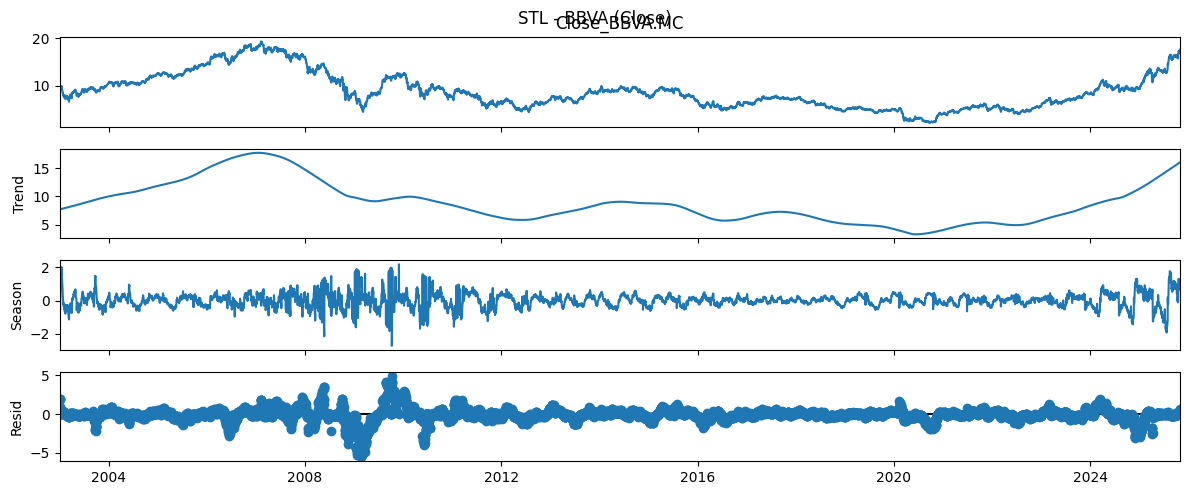

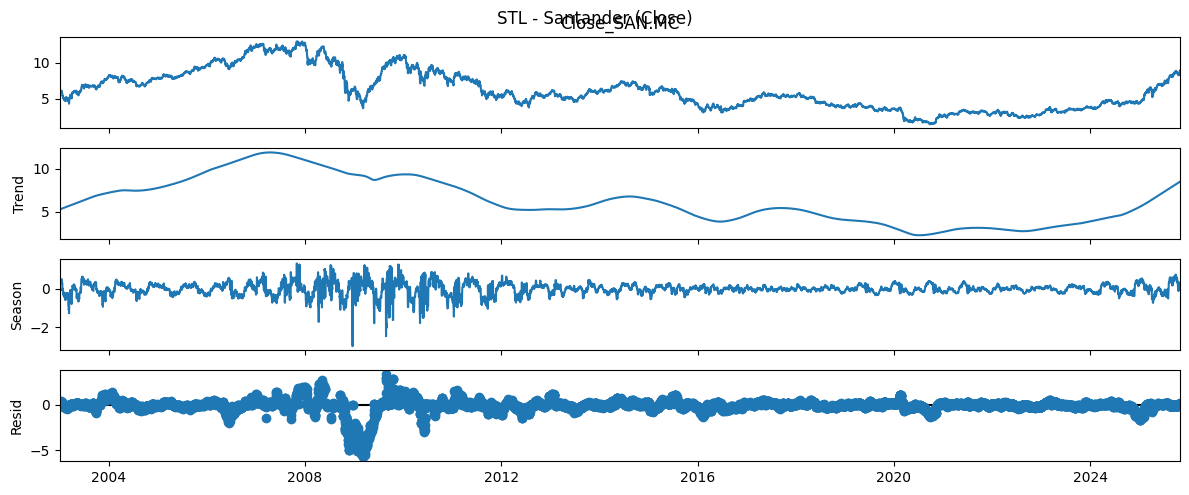

In [149]:
# STL BBVA
stl_bbva = STL(bbva['Close_BBVA.MC'].dropna(), period=252, robust=True).fit()
stl_bbva.plot()
plt.suptitle("STL - BBVA (Close)")
plt.show()

# STL Santander
stl_san = STL(san['Close_SAN.MC'].dropna(), period=252, robust=True).fit()
stl_san.plot()
plt.suptitle("STL - Santander (Close)")
plt.show()


#### Filtro HP (macro: Euribor/IPC/PIB/desempleo)
Explicación: HP separa tendencia larga y ciclo. Para series macro (mensuales o trimestrales) tendrás que ajustar lamb. Para datos diarios usareamos lamb=1600 como punto de partida pero para series macro con baja frecuencia considera lamb mayores (e.g., 129600 para series mensuales — ajusta según frecuencia).

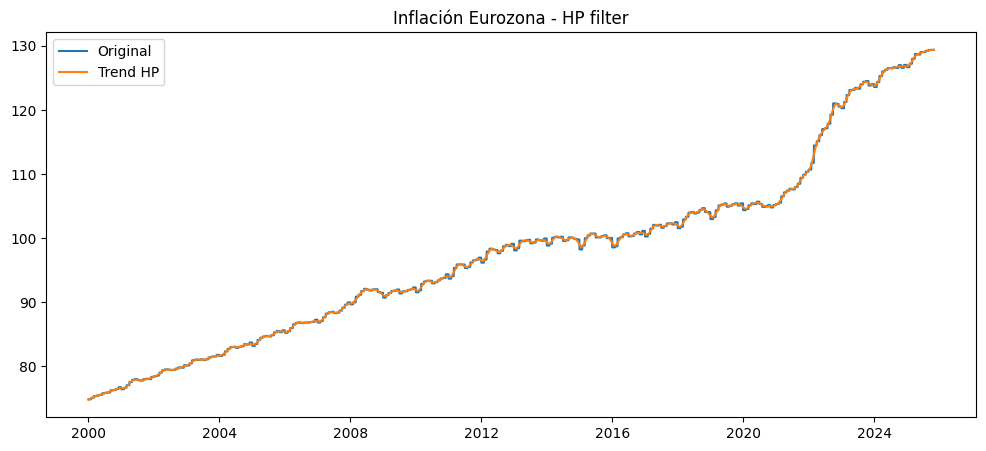

In [150]:
# Ejemplo con inflación Eurozona (si está en macro)
series = macro['inflacion_eurozona'].dropna()
if not series.empty:
    cycle, trend = hpfilter(series, lamb=129600)  # ejemplo para monthly-like series
    plt.figure()
    plt.plot(series.index, series, label='Original')
    plt.plot(trend.index, trend, label='Trend HP')
    plt.title("Inflación Eurozona - HP filter")
    plt.legend()
    plt.show()
else:
    print("No hay serie de 'inflacion_eurozona' en macro.")


Repite para desempleo_espana, Euribor, PIB (ajusta lamb según frecuencia).

#### 3. Detección de picos (VIX, IBEX, Brent, prima de riesgo) — rolling mean + z-score
Explicación: marcador robusto para identificar días de estrés: calculamos z-score usando rolling() y señalamos valores con |z| > umbral.


In [ ]:
def detect_peaks_z(serie, window=60, threshold=2.0):
    rm = serie.rolling(window).mean()
    rs = serie.rolling(window).std()
    z = (serie - rm) / rs
    peaks = z.abs() > threshold
    return peaks, z

# Ejemplo VIX (si existe)
if 'VIX' in joint.columns:
    peaks_vix, z_vix = detect_peaks_z(joint['VIX'].dropna(), window=60, threshold=2.0)
    plt.plot(joint['VIX'], label='VIX')
    plt.scatter(joint['VIX'][peaks_vix].index, joint['VIX'][peaks_vix], color='red', label='Peaks')
    plt.title("Picos VIX (zscore rolling)")
    plt.legend()
    plt.show()
else:
    print("No hay VIX en joint.")


No hay VIX en joint.


Haz lo mismo para IBEX (si lo tienes), Brent (si lo tienes) y prima_de_riesgo (o proxy, e.g. spread bonos).

#### 4. Marcar fechas de picos comunes entre variables
Explicación: detectamos picos (boolean) para varias series, sumamos y tomamos fechas donde >= 2 o >=3 series coinciden — eso marca shocks sistémicos.

In [152]:
# Detectar picos para varias series (ajusta nombres según tu macro df)
candidates = {}
for col in ['VIX', 'IBEX_Close', 'Brent', 'prima_riesgo']:  # ajusta a tus columnas
    if col in joint.columns:
        p, _ = detect_peaks_z(joint[col].dropna(), window=60, threshold=2.0)
        candidates[col] = p

# Unir booleans por índice
peaks_df = pd.DataFrame(candidates).fillna(False)
if not peaks_df.empty:
    peaks_df['common_count'] = peaks_df.sum(axis=1)
    common_shocks = peaks_df[peaks_df['common_count'] >= 2]
    print("Fechas con picos simultáneos (>=2 series):")
    print(common_shocks.index.date[:50])
else:
    print("No se detectaron series para comparar picos.")


No se detectaron series para comparar picos.


#### 5.Correlaciones dinámicas.
Explicación: cómo cambian las correlaciones BBVA vs Santander, BBVA vs VIX, etc., a lo largo del tiempo.

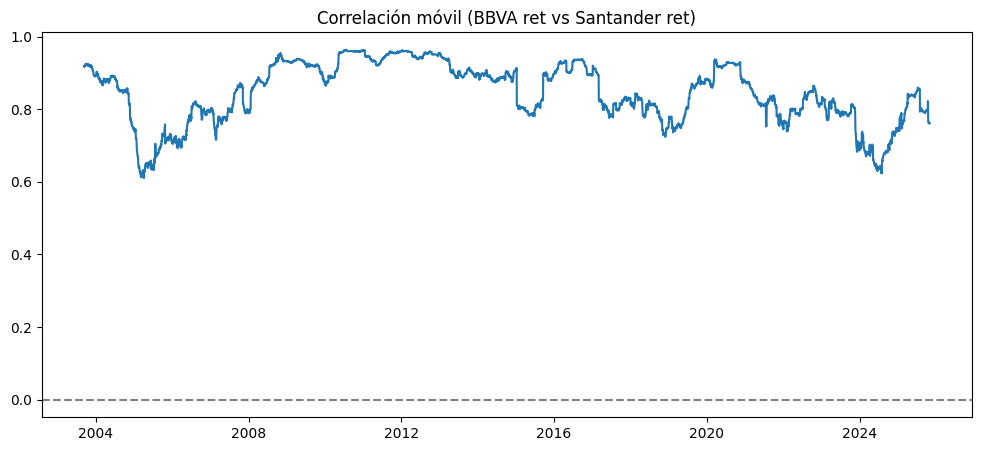

In [153]:
window = 252  # 1 año approx
# BBVA vs Santander closing prices log-returns
corr_bbva_san = bbva['ret'].rolling(window).corr(san['ret'])
plt.plot(corr_bbva_san)
plt.title("Correlación móvil (BBVA ret vs Santander ret)")
plt.axhline(0, linestyle='--', color='gray')
plt.show()

# BBVA vs VIX (ret vs level o ret vs ret)
if 'VIX' in joint.columns:
    corr_bbva_vix = bbva['ret'].rolling(window).corr(joint['VIX'])
    plt.plot(corr_bbva_vix)
    plt.title("Correlación móvil (BBVA ret vs VIX level)")
    plt.show()


ota: VIX es nivel y BBVA es retorno; puedes correlacionar ret con VIX o con ret(VIX) si lo prefieres.

#### 6. Volatilidad: rolling + GARCH
xplicación: estimamos volatilidad condicional con GARCH(1,1) y comparamos con volatilidad rolling.

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -15398.6
Distribution:                  Normal   AIC:                           30805.3
Method:            Maximum Likelihood   BIC:                           30833.4
                                        No. Observations:                 8338
Date:                Sun, Nov 09 2025   Df Residuals:                     8337
Time:                        18:54:14   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0368  1.543e-02      2.384  1.713e-02 [6.

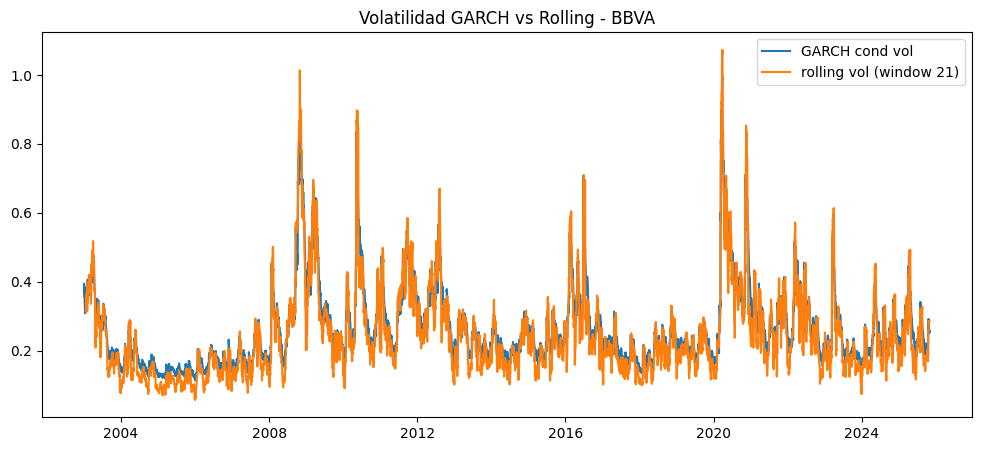

In [154]:
# Rolling vol ya calculada en preparación (vol_roll). Vamos a ajustar GARCH a los retornos de BBVA
bbva_rets = bbva['ret'].dropna()*100  # % returns

# Ajustar GARCH(1,1) (modela var cond)
am = arch_model(bbva_rets, vol='Garch', p=1, q=1, dist='normal')
res = am.fit(disp='off')
print(res.summary())

# Volatilidad condicional estimada (annualized)
cond_vol = res.conditional_volatility / 100 * np.sqrt(252)
plt.plot(cond_vol, label='GARCH cond vol')
plt.plot(bbva['vol_roll'], label='rolling vol (window {})'.format(window_vol))
plt.legend()
plt.title("Volatilidad GARCH vs Rolling - BBVA")
plt.show()


Repite para santander 


#### 7. Cointegración (BBVA vs Santander)
Explicación: testea si existe relación de largo plazo entre los precios (útil para pares trading).

In [155]:
# Usar precios (nivel); quitar NaNs
p1 = bbva['Close_BBVA.MC'].dropna()
p2 = san['Close_SAN.MC'].dropna()
# Alinear
dfp = pd.concat([p1, p2], axis=1).dropna()
score, pvalue, _ = coint(dfp.iloc[:,0], dfp.iloc[:,1])
print("Cointegration test p-value:", pvalue)
if pvalue < 0.05:
    print("Hay cointegración significativa (p < 0.05).")
else:
    print("No hay evidencia fuerte de cointegración.")


Cointegration test p-value: 0.9326805277947765
No hay evidencia fuerte de cointegración.


#### 8.Cross-correlation lag analysis (¿un indicador anticipa a otro?)
Explicación: usar CCF o correlaciones con lags para ver si VIX anticipa movimientos en BBVA, etc.

In [156]:
from statsmodels.tsa.stattools import ccf

# Tomar series limpias y standardize
vix = joint['VIX'].dropna().loc[dfp.index.min():dfp.index.max()] if 'VIX' in joint.columns else None
bbva_ret = bbva['ret'].dropna().loc[dfp.index.min():dfp.index.max()]

if vix is not None:
    # Resample to align and dropna
    tmp = pd.concat([bbva_ret, vix], axis=1).dropna()
    x = (tmp['VIX'] - tmp['VIX'].mean())/tmp['VIX'].std()
    y = (tmp['ret'] - tmp['ret'].mean())/tmp['ret'].std()
    # ccf gives correlation at lags (positive lag => x leads y)
    lags = 30
    c = ccf(x, y)[:lags]
    plt.bar(range(len(c)), c)
    plt.axhline(0, color='k', linestyle='--')
    plt.title("CCF: VIX vs BBVA ret (pos lag => VIX leads BBVA)")
    plt.show()
else:
    print("No VIX para análisis de cross-corr.")


No VIX para análisis de cross-corr.


#### 9. Clusterización de periodos de crisis (PCA + KMeans)
Explicación: transformamos variables de estrés (VIX, vol rol, spreads, returns) a componentes y clusterizamos para identificar regimes (tranquilo vs estresado).

Cluster 0 - count: 1093
Cluster 1 - count: 6316
Cluster 2 - count: 909


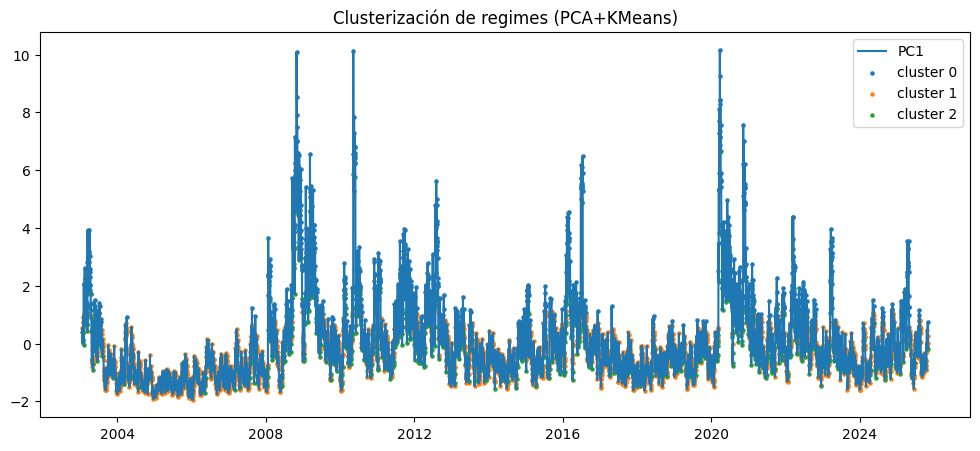

In [157]:
# Construir matrix de features por día (ajusta columnas)
features = pd.DataFrame({
    'BBVA_ret': bbva['ret'],
    'SAN_ret': san['ret'],
    'BBVA_vol': bbva['vol_roll'],
    'SAN_vol': san['vol_roll'],
})
# Añadir VIX y prima_riesgo si existen
for col in ['VIX','prima_riesgo','Brent']:
    if col in joint.columns:
        features[col] = joint[col]

features = features.dropna()

# Standardize
X = (features - features.mean()) / features.std()

# PCA para reducción
pca = PCA(n_components=3)
Z = pca.fit_transform(X)

# KMeans (2 or 3 clusters)
k = 3
km = KMeans(n_clusters=k, random_state=42).fit(Z)
labels = km.labels_

# Añadir etiquetas al df y ver periodos
features['cluster'] = labels
for i in range(k):
    print(f"Cluster {i} - count:", (features['cluster']==i).sum())

# Plot clusters on first PCA component timeline
plt.plot(pd.to_datetime(features.index), Z[:,0], label='PC1')
for i in range(k):
    idx = features.index[features['cluster']==i]
    plt.scatter(idx, Z[features['cluster']==i,0], s=5, label=f'cluster {i}')
plt.legend()
plt.title("Clusterización de regimes (PCA+KMeans)")
plt.show()


#### 10. Resumen de fechas críticas y salida para informe
Explicación: creamos una tabla con las fechas donde múltiples indicadores marcaron picos (vinculable a eventos históricos).

In [158]:
# Generar tabla de fechas críticas (union de picos de BBVA, SAN, VIX y prima)
peaks_list = {}
for name, ser in [('BBVA', bbva['ret']), ('SAN', san['ret']), ('VIX', joint.get('VIX'))]:
    if ser is not None:
        p, z = detect_peaks_z(ser.abs(), window=60, threshold=2.0)
        peaks_list[name] = p

peaks_tbl = pd.DataFrame(peaks_list).fillna(False)
peaks_tbl['count'] = peaks_tbl.sum(axis=1)
critical_dates = peaks_tbl[peaks_tbl['count'] >= 2].index
print("Fechas críticas detectadas (ejemplos):")
print(critical_dates.date[:50])

# Guardar CSV con las fechas y qué series hicieron pico
peaks_tbl.to_csv("peaks_by_series.csv")

Fechas críticas detectadas (ejemplos):
[datetime.date(2003, 3, 13) datetime.date(2003, 3, 14)
 datetime.date(2003, 5, 19) datetime.date(2003, 10, 3)
 datetime.date(2003, 11, 17) datetime.date(2003, 12, 1)
 datetime.date(2004, 1, 2) datetime.date(2004, 1, 29)
 datetime.date(2004, 2, 6) datetime.date(2004, 3, 11)
 datetime.date(2004, 3, 15) datetime.date(2004, 3, 17)
 datetime.date(2004, 5, 10) datetime.date(2004, 5, 19)
 datetime.date(2004, 7, 27) datetime.date(2004, 10, 1)
 datetime.date(2004, 10, 4) datetime.date(2004, 11, 17)
 datetime.date(2005, 3, 16) datetime.date(2005, 4, 15)
 datetime.date(2005, 7, 7) datetime.date(2005, 9, 26)
 datetime.date(2005, 9, 28) datetime.date(2005, 10, 31)
 datetime.date(2006, 1, 25) datetime.date(2006, 1, 26)
 datetime.date(2006, 2, 22) datetime.date(2006, 4, 21)
 datetime.date(2006, 5, 12) datetime.date(2006, 5, 17)
 datetime.date(2006, 5, 22) datetime.date(2006, 6, 8)
 datetime.date(2006, 10, 17) datetime.date(2006, 11, 24)
 datetime.date(2006, 11, 

#### Entrenamiento y modelado para BBVA 

In [159]:
import pandas as pd

BBVA_data = pd.read_csv("bbva_completo.csv")
SANTANDER_data = pd.read_csv("santander_completo.csv")

print(BBVA_data.columns)
print(SANTANDER_data.columns)


Index(['Date', 'Adj Close_BBVA.MC', 'Close_BBVA.MC', 'Dividends_BBVA.MC',
       'High_BBVA.MC', 'Low_BBVA.MC', 'Open_BBVA.MC', 'Stock Splits_BBVA.MC',
       'Volume_BBVA.MC', 'tasa_interes', 'inflacion', 'PIB', 'desempleo',
       'tipo_cambio', 'liquidez_M2', 'materias_primas', 'politica_monetaria',
       'sentimiento_global', 'inflacion_eurozona', 'desempleo_espana',
       '('VIX', '^VIX')'],
      dtype='object')
Index(['Date', 'Adj Close_SAN.MC', 'Close_SAN.MC', 'Dividends_SAN.MC',
       'High_SAN.MC', 'Low_SAN.MC', 'Open_SAN.MC', 'Stock Splits_SAN.MC',
       'Volume_SAN.MC', 'tasa_interes', 'inflacion', 'PIB', 'desempleo',
       'tipo_cambio', 'liquidez_M2', 'materias_primas', 'politica_monetaria',
       'sentimiento_global', 'inflacion_eurozona', 'desempleo_espana',
       '('VIX', '^VIX')'],
      dtype='object')


Entrenando modelos para BBVA con 5852 registros...

🔹 Entrenando modelo SimpleRNN para BBVA
Epoch 1/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0372

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0101
Epoch 2/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0637e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3773e-04
Epoch 3/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3327e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5612e-04
Epoch 4/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9426e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2260e-04
Epoch 5/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6238e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8422e-04
Epoch 6/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4460e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6458e-04
Epoch 7/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3800e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5500e-04
Epoch 8/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2641e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4031e-04
Epoch 9/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1965e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3684e-04
Epoch 10/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0969e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2455e-04
Epoch 11/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0364e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1686e-04
Epoch 12/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9653e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0878e-04
Epoch 13/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9329e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0505e-04
Epoch 14/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8857e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0016e-04
Epoch 15/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8768e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9974e-04
Epoch 16/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8538e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9629e-04
Epoch 17/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7711e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8860e-04
Epoch 18/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7437e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8675e-04
Epoch 19/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7204e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8421e-04
Epoch 20/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7139e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8341e-04
Epoch 21/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6841e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8037e-04
Epoch 22/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8163e-04
Epoch 23/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6745e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7931e-04
Epoch 24/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6597e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7786e-04
Epoch 25/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6361e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7582e-04
Epoch 26/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7711e-04
Epoch 27/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6512e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7556e-04
Epoch 28/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6307e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7417e-04
Epoch 29/80
169/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6235e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7413e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7464e-04
Epoch 31/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7439e-04
Epoch 32/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6247e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7375e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7379e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7433e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7399e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7402e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7428e-04
Epoch 38/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7534e-04
Epoch 39/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7428e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7571e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


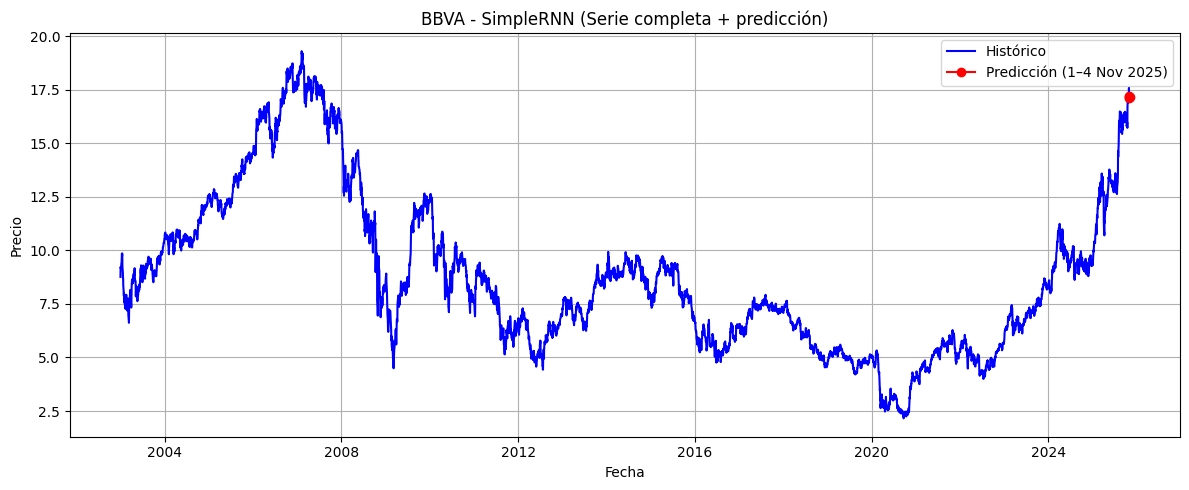

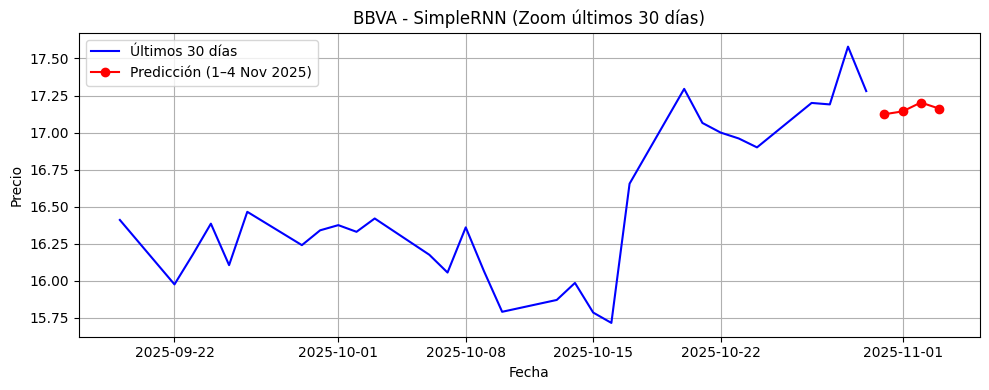


🔹 Entrenando modelo LSTM para BBVA
Epoch 1/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0352

181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0097
Epoch 2/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1171e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.0756e-04
Epoch 3/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4360e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.5452e-04
Epoch 4/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7432e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.8868e-04
Epoch 5/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3227e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.5047e-04
Epoch 6/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0729e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.2867e-04
Epoch 7/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9069e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.1089e-04
Epoch 8/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.7080e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.8993e-04
Epoch 9/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5551e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.7420e-04
Epoch 10/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4432e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.6230e-04
Epoch 11/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.3415e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.5165e-04
Epoch 12/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2592e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4366e-04
Epoch 13/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1802e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.3529e-04
Epoch 14/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1157e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2824e-04
Epoch 15/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0545e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.2170e-04
Epoch 16/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9998e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1594e-04
Epoch 17/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9612e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1159e-04
Epoch 18/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9212e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.0733e-04
Epoch 19/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8834e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.0303e-04
Epoch 20/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8578e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.9982e-04
Epoch 21/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8362e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9723e-04
Epoch 22/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8072e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9449e-04
Epoch 23/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.7894e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.9173e-04
Epoch 24/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.7651e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.8875e-04
Epoch 25/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.7541e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.8730e-04
Epoch 26/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.7288e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.8432e-04
Epoch 27/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.7206e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.8313e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.7074e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.8158e-04
Epoch 29/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6984e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.8032e-04
Epoch 30/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.6846e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.7865e-04
Epoch 31/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6803e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.7836e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6713e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7724e-04
Epoch 33/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6567e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7547e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7589e-04
Epoch 35/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.6476e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7470e-04
Epoch 36/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6474e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7446e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6423e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7362e-04
Epoch 38/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6386e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7327e-04
Epoch 39/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6302e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.7249e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7274e-04
Epoch 41/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6237e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7136e-04
Epoch 42/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.7182e-04
Epoch 43/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.7188e-04
Epoch 44/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6188e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7117e-04
Epoch 45/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6221e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7082e-04
Epoch 46/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6150e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.7067e-04
Epoch 47/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7106e-04
Epoch 48/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7139e-04
Epoch 49/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.7198e-04
Epoch 50/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.7223e-04
Epoch 51/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.7209e-04
Epoch 52/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7365e-04
Epoch 53/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7415e-04
Epoch 54/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.7423e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


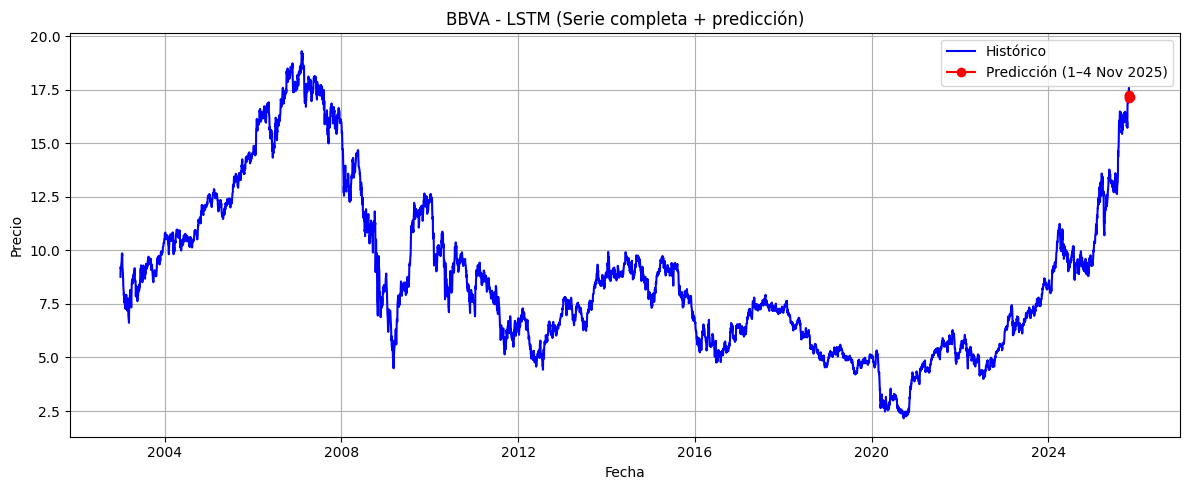

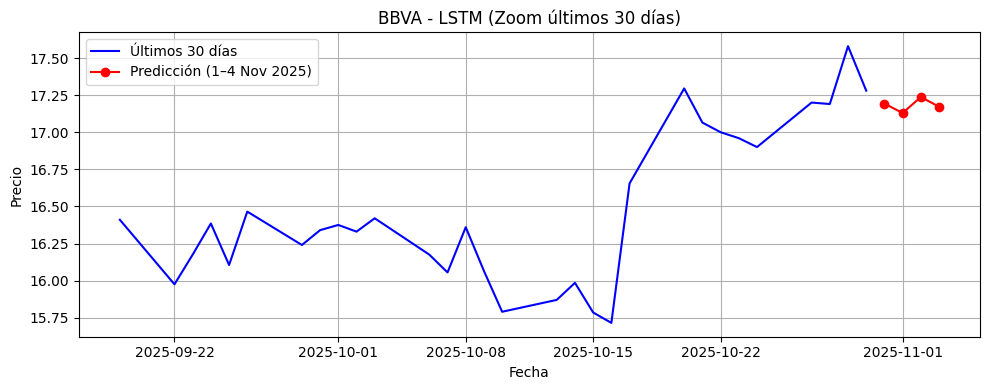


🔹 Entrenando modelo GRU para BBVA
Epoch 1/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0544

181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0169
Epoch 2/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.4100e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.4127e-04
Epoch 3/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.2243e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.3005e-04
Epoch 4/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1188e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.1872e-04
Epoch 5/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.9963e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.0721e-04
Epoch 6/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8942e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.9838e-04
Epoch 7/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8356e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.9415e-04
Epoch 8/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8133e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.9271e-04
Epoch 9/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7969e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.9203e-04
Epoch 10/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.7775e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.9034e-04
Epoch 11/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7599e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8859e-04
Epoch 12/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7511e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8781e-04
Epoch 13/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7343e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.8621e-04
Epoch 14/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7181e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8437e-04
Epoch 15/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7125e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8313e-04
Epoch 16/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6958e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8164e-04
Epoch 17/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.6907e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8075e-04
Epoch 18/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6858e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.8069e-04
Epoch 19/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6788e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.7897e-04
Epoch 20/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.6764e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.7838e-04
Epoch 21/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.6716e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.7799e-04
Epoch 22/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6584e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7745e-04
Epoch 23/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.6598e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.7645e-04
Epoch 24/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.6539e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 2.7587e-04
Epoch 25/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6465e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.7557e-04
Epoch 26/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7557e-04
Epoch 27/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6376e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.7431e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7432e-04
Epoch 29/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6334e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.7373e-04
Epoch 30/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6318e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.7337e-04
Epoch 31/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6337e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.7312e-04
Epoch 32/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6316e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.7275e-04
Epoch 33/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.6240e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.7246e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.7262e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.6255e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.7206e-04
Epoch 36/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.6228e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 2.7198e-04
Epoch 37/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.6160e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2.7189e-04
Epoch 38/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6209e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.7185e-04
Epoch 39/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.6205e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2.7176e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2.7205e-04
Epoch 41/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7302e-04
Epoch 42/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7343e-04
Epoch 43/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.7374e-04
Epoch 44/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7431e-04
Epoch 45/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.7493e-04
Epoch 46/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.7617e-04
Epoch 47/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.7727e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


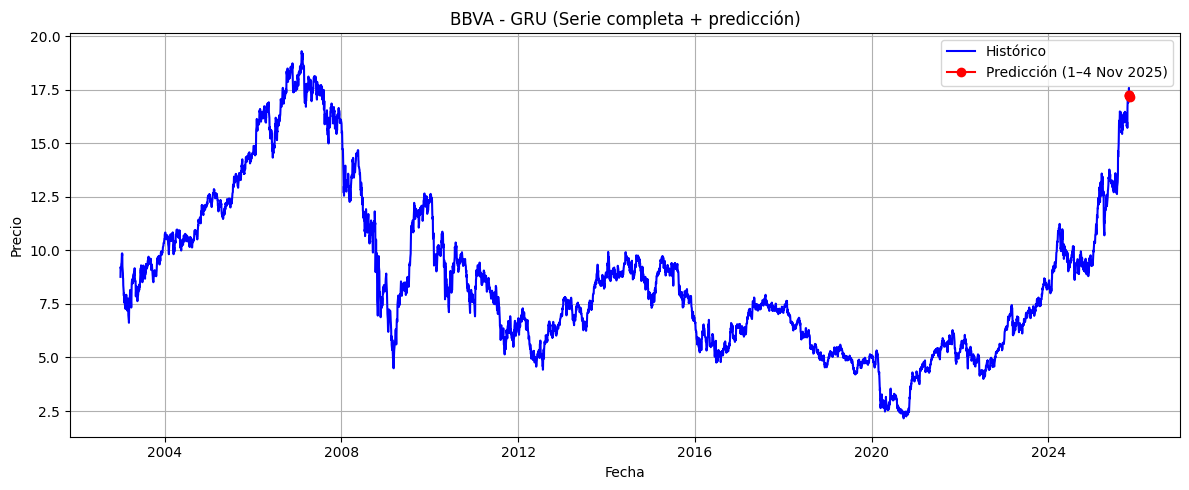

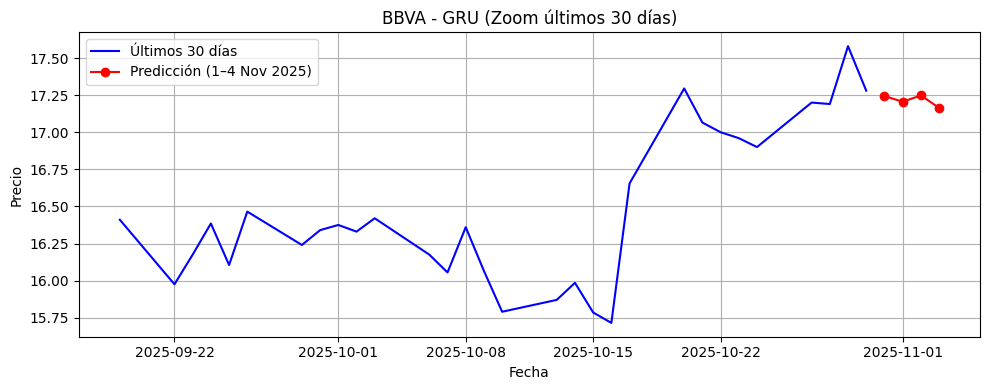

Entrenando modelos para SANTANDER con 5852 registros...

🔹 Entrenando modelo SimpleRNN para SANTANDER
Epoch 1/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0357

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0086
Epoch 2/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0586e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2743e-04
Epoch 3/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5428e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.7691e-04
Epoch 4/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2932e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4302e-04
Epoch 5/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1440e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2168e-04
Epoch 6/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0392e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.1213e-04
Epoch 7/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8635e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.9335e-04
Epoch 8/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7444e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8015e-04
Epoch 9/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6293e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6840e-04
Epoch 10/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5636e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6156e-04
Epoch 11/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5134e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5492e-04
Epoch 12/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4550e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4903e-04
Epoch 13/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4516e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.4671e-04
Epoch 14/80
170/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3813e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4142e-04
Epoch 15/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3851e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4095e-04
Epoch 16/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3344e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3720e-04
Epoch 17/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3090e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3481e-04
Epoch 18/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2975e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3420e-04
Epoch 19/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2828e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3368e-04
Epoch 20/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2765e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3190e-04
Epoch 21/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2506e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2979e-04
Epoch 22/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2198e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2730e-04
Epoch 23/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2042e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2722e-04
Epoch 24/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2140e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2711e-04
Epoch 25/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1833e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2450e-04
Epoch 26/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2678e-04
Epoch 27/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2662e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2644e-04
Epoch 29/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2541e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2556e-04
Epoch 31/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1551e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2284e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2542e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2431e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2569e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2556e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2373e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2621e-04
Epoch 38/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2509e-04
Epoch 39/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2542e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


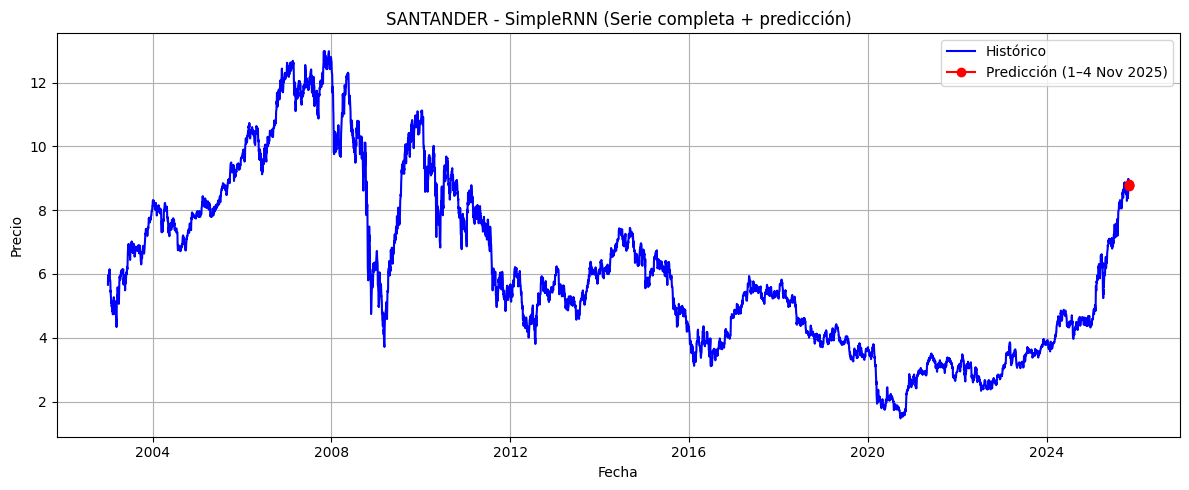

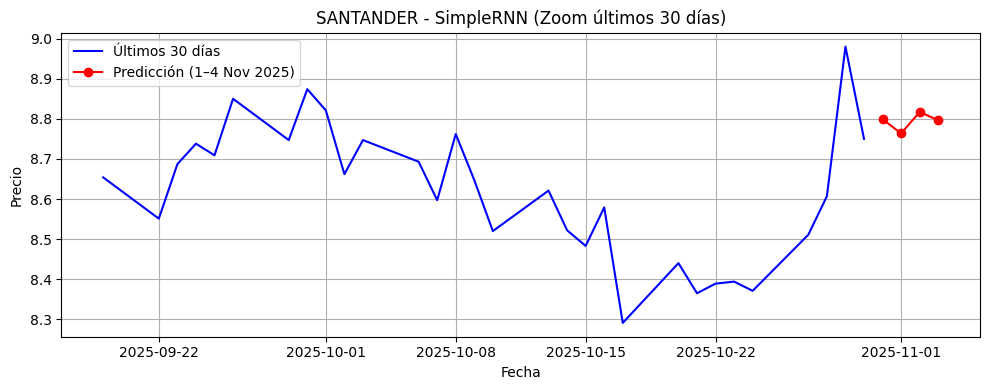


🔹 Entrenando modelo LSTM para SANTANDER
Epoch 1/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0425

181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0121
Epoch 2/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.5317e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.4845e-04
Epoch 3/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.8517e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 5.9309e-04
Epoch 4/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.3685e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 5.4316e-04
Epoch 5/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.0176e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 5.1308e-04
Epoch 6/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.7442e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 4.8561e-04
Epoch 7/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.5031e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 4.6297e-04
Epoch 8/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.3151e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 4.4641e-04
Epoch 9/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1658e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 4.3223e-04
Epoch 10/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0408e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 4.2005e-04
Epoch 11/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.9280e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 4.0760e-04
Epoch 12/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.8240e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.9847e-04
Epoch 13/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.7596e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.8954e-04
Epoch 14/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6659e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.7966e-04
Epoch 15/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.6137e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.7326e-04
Epoch 16/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.5643e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.6800e-04
Epoch 17/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.5114e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.6142e-04
Epoch 18/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.4494e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.5517e-04
Epoch 19/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.4242e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.5245e-04
Epoch 20/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.3912e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.4841e-04
Epoch 21/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.3765e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 3.4586e-04
Epoch 22/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.3295e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 3.4137e-04
Epoch 23/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.3312e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.4007e-04
Epoch 24/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.3084e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.3866e-04
Epoch 25/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.2836e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.3637e-04
Epoch 26/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.2622e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.3415e-04
Epoch 27/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.2368e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.3225e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.2338e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.3158e-04
Epoch 29/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.2212e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.3016e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.2095e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2914e-04
Epoch 31/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2969e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.1917e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3.2839e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.1827e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2809e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.1779e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2756e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.1699e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2664e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.1582e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2661e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2665e-04
Epoch 38/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2666e-04
Epoch 39/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.1439e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2643e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.1339e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2536e-04
Epoch 41/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2603e-04
Epoch 42/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2609e-04
Epoch 43/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.1103e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2492e-04
Epoch 44/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.1028e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2445e-04
Epoch 45/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.0982e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.2387e-04
Epoch 46/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.1058e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2340e-04
Epoch 47/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.0916e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2312e-04
Epoch 48/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.0778e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2225e-04
Epoch 49/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.0689e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2099e-04
Epoch 50/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2110e-04
Epoch 51/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.0629e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.2069e-04
Epoch 52/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0531e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1910e-04
Epoch 53/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1931e-04
Epoch 54/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1931e-04
Epoch 55/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0412e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1890e-04
Epoch 56/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0370e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1830e-04
Epoch 57/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0317e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1797e-04
Epoch 58/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0302e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.1752e-04
Epoch 59/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0264e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.1659e-04
Epoch 60/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0260e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1623e-04
Epoch 61/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1648e-04
Epoch 62/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0190e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1608e-04
Epoch 63/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0148e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.1563e-04
Epoch 64/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0090e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1552e-04
Epoch 65/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0067e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.1461e-04
Epoch 66/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1526e-04
Epoch 67/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.9987e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.1398e-04
Epoch 68/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.1458e-04
Epoch 69/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.9998e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1390e-04
Epoch 70/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1399e-04
Epoch 71/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.9941e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.1265e-04
Epoch 72/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1443e-04
Epoch 73/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.1334e-04
Epoch 74/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9897e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1239e-04
Epoch 75/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9813e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1205e-04
Epoch 76/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9782e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1175e-04
Epoch 77/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1189e-04
Epoch 78/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9794e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1173e-04
Epoch 79/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9776e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1127e-04
Epoch 80/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1201e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


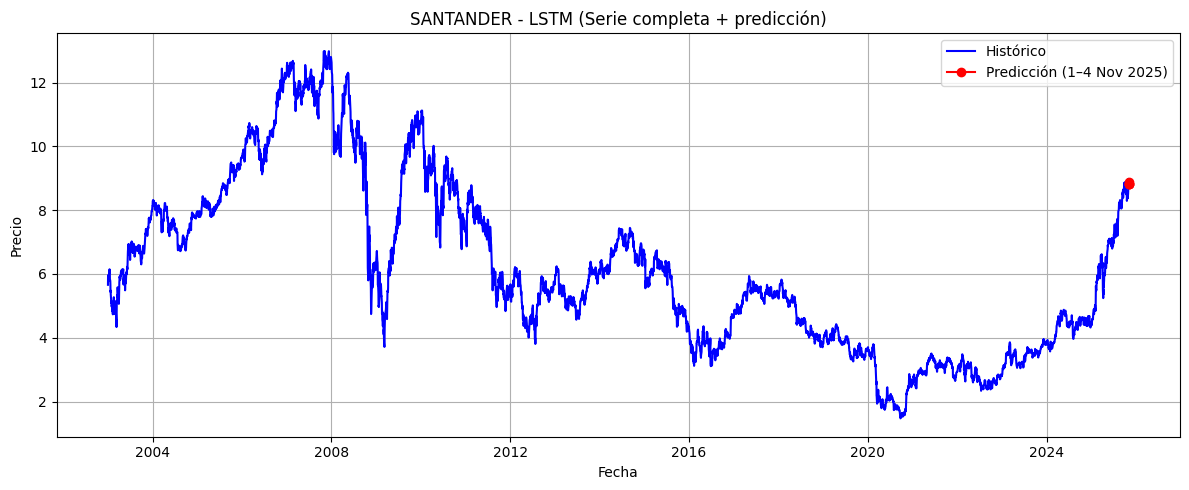

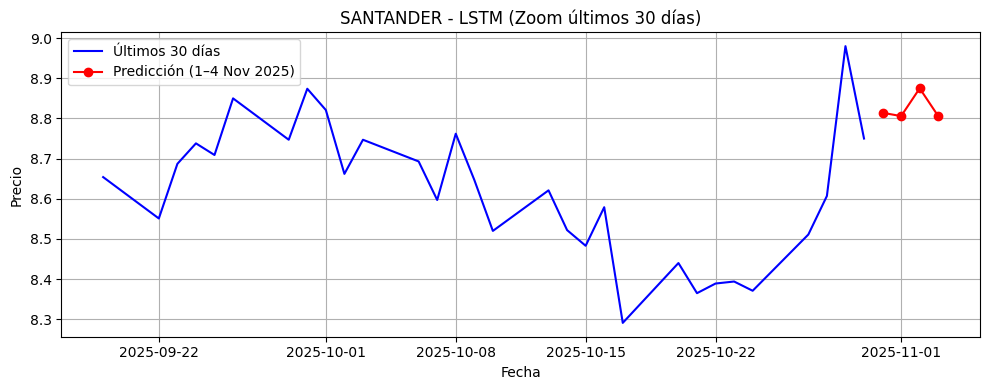


🔹 Entrenando modelo GRU para SANTANDER
Epoch 1/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0594

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0185
Epoch 2/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7277e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.8105e-04
Epoch 3/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4373e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.5499e-04
Epoch 4/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.3370e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.4856e-04
Epoch 5/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.3260e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.4704e-04
Epoch 6/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.3230e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.4398e-04
Epoch 7/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.3220e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.4334e-04
Epoch 8/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.3289e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.4245e-04
Epoch 9/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.3285e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.4229e-04
Epoch 10/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.3183e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.4129e-04
Epoch 11/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.3170e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.4077e-04
Epoch 12/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2942e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.3835e-04
Epoch 13/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2825e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.3790e-04
Epoch 14/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.2903e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.3788e-04
Epoch 15/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2544e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 3.3476e-04
Epoch 16/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 3.3522e-04
Epoch 17/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.2484e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.3384e-04
Epoch 18/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2313e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.3242e-04
Epoch 19/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2271e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.3148e-04
Epoch 20/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2035e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2949e-04
Epoch 21/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2023e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.2926e-04
Epoch 22/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1843e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2826e-04
Epoch 23/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1821e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.2762e-04
Epoch 24/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1756e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.2728e-04
Epoch 25/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.2742e-04
Epoch 26/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1699e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.2708e-04
Epoch 27/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1606e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2649e-04
Epoch 28/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1573e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2598e-04
Epoch 29/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1505e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2582e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2652e-04
Epoch 31/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1359e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2500e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2536e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2504e-04
Epoch 34/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1285e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2494e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2574e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2562e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2516e-04
Epoch 38/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2551e-04
Epoch 39/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2657e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.2624e-04
Epoch 41/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2543e-04
Epoch 42/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2541e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


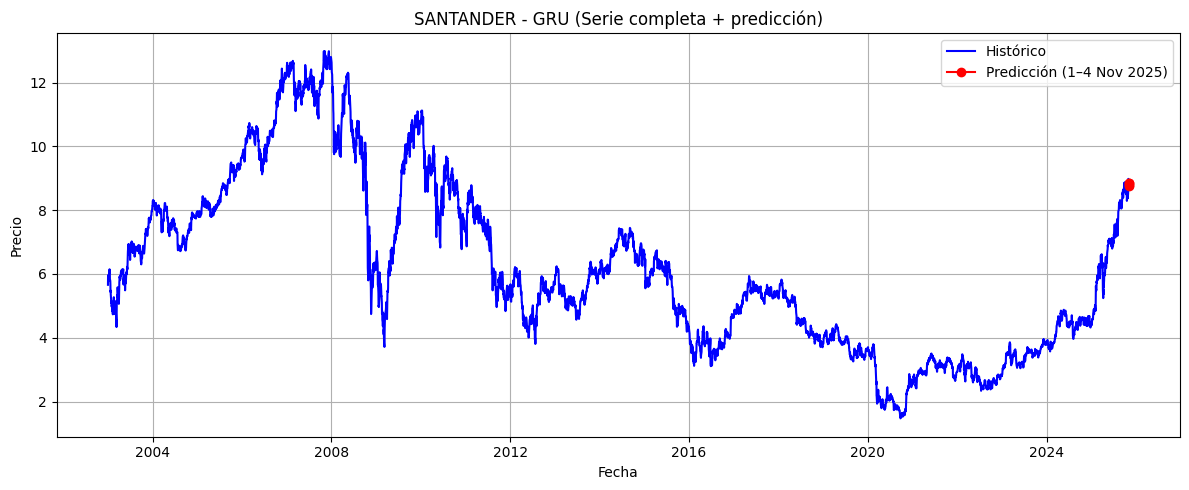

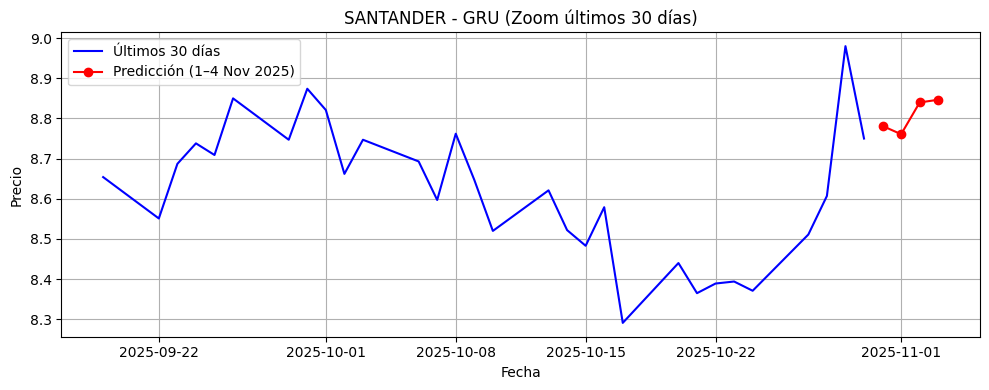


✅ Predicciones completadas. Modelos guardados en: modelos_prediccion_noviembre


In [160]:
# -------------------------------------------
# Celda: Predicción futura multi-step (versión ajustada a noviembre 2025)
# -------------------------------------------
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---------- parámetros ----------
timesteps = 60
forecast_days = 4  # predicción 1–4 de noviembre 2025
epochs = 80
batch_size = 32
patience = 8
models_dir = "modelos_prediccion_noviembre"
os.makedirs(models_dir, exist_ok=True)

# ---------- cargar datos ----------
BBVA_data = pd.read_csv("bbva_completo.csv")
SANTANDER_data = pd.read_csv("santander_completo.csv")

# Se asume que las columnas son "Date" y "Close_XXX.MC"
BBVA_data['Date'] = pd.to_datetime(BBVA_data['Date'])
SANTANDER_data['Date'] = pd.to_datetime(SANTANDER_data['Date'])

# ---------- utilidades ----------
def create_sequences(series, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(series) - n_steps_in - n_steps_out + 1):
        X.append(series[i:i+n_steps_in])
        y.append(series[i+n_steps_in:i+n_steps_in+n_steps_out])
    X = np.array(X).reshape(-1, n_steps_in, 1)
    y = np.array(y)
    return X, y

def build_rnn(model_type='LSTM', n_steps_in=timesteps, n_steps_out=forecast_days, units=64):
    model = Sequential()
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(units, input_shape=(n_steps_in, 1)))
    elif model_type == 'GRU':
        model.add(GRU(units, input_shape=(n_steps_in, 1)))
    else:
        model.add(LSTM(units, input_shape=(n_steps_in, 1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    return model

# ---------- función principal ----------
def train_and_predict(df_stock, stock_name):
    series = df_stock['Close'].dropna().values.reshape(-1, 1)
    dates = pd.to_datetime(df_stock['Date'].values)

    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    X_train, y_train = create_sequences(series_scaled, timesteps, forecast_days)
    print(f"Entrenando modelos para {stock_name} con {len(series)} registros...")

    models = ['SimpleRNN', 'LSTM', 'GRU']
    results = {}

    # Usamos los últimos timesteps para hacer la predicción futura
    last_window = series_scaled[-timesteps:].reshape(1, timesteps, 1)

    for arch in models:
        print(f"\n🔹 Entrenando modelo {arch} para {stock_name}")
        model = build_rnn(model_type=arch)
        ckpt_path = os.path.join(models_dir, f"{stock_name}_{arch}_forecast.h5")

        callbacks = [
            EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True),
            ModelCheckpoint(ckpt_path, monitor='loss', save_best_only=True, verbose=0)
        ]

        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=callbacks
        )

        # Predicción de los próximos 4 días
        pred_scaled = model.predict(last_window).flatten()
        pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

        # Generar nuevas fechas para 1-4 de noviembre 2025
        last_date = dates[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)

        # Guardar resultados
        results[arch] = {
            "model": model,
            "forecast": pred,
            "future_dates": future_dates,
            "ckpt_path": ckpt_path,
            "history": history.history
        }

        # -------- Gráfico 1: histórico completo + predicción --------
        plt.figure(figsize=(12,5))
        plt.plot(dates, series, label='Histórico', color='blue')
        plt.plot(future_dates, pred, 'ro-', label='Predicción (1–4 Nov 2025)')
        plt.title(f"{stock_name} - {arch} (Serie completa + predicción)")
        plt.xlabel("Fecha")
        plt.ylabel("Precio")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # -------- Gráfico 2: últimos 30 días + predicción --------
        plt.figure(figsize=(10,4))
        plt.plot(dates[-30:], series[-30:], label='Últimos 30 días', color='blue')
        plt.plot(future_dates, pred, 'ro-', label='Predicción (1–4 Nov 2025)')
        plt.title(f"{stock_name} - {arch} (Zoom últimos 30 días)")
        plt.xlabel("Fecha")
        plt.ylabel("Precio")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return results

# ---------- Ejecutar para BBVA y SANTANDER ----------
bbva_res = train_and_predict(
    BBVA_data[['Date', 'Close_BBVA.MC']].rename(columns={'Close_BBVA.MC': 'Close'}),
    "BBVA"
)

san_res = train_and_predict(
    SANTANDER_data[['Date', 'Close_SAN.MC']].rename(columns={'Close_SAN.MC': 'Close'}),
    "SANTANDER"
)

print("\n✅ Predicciones completadas. Modelos guardados en:", models_dir)


CODIGO MEJORADO VERSION PROFESIONAL


📈 Entrenando modelos para BBVA con 5852 registros...

🔹 Entrenando modelo SimpleRNN para BBVA
Epoch 1/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0305

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0073
Epoch 2/80
170/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0427e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.9785e-04
Epoch 3/80
168/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5779e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5420e-04
Epoch 4/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2692e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2482e-04
Epoch 5/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0156e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9893e-04
Epoch 6/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8333e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8263e-04
Epoch 7/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6969e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.6945e-04
Epoch 8/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5818e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6010e-04
Epoch 9/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5203e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5222e-04
Epoch 10/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5111e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4816e-04
Epoch 11/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3806e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4121e-04
Epoch 12/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3610e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3843e-04
Epoch 13/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3283e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3556e-04
Epoch 14/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2986e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3138e-04
Epoch 15/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2652e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2967e-04
Epoch 16/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2798e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2923e-04
Epoch 17/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2708e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2828e-04
Epoch 18/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2583e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2651e-04
Epoch 19/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2334e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2532e-04
Epoch 20/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2202e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2444e-04
Epoch 21/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2078e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2426e-04
Epoch 22/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1776e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2055e-04
Epoch 23/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1657e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1934e-04
Epoch 24/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1614e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1905e-04
Epoch 25/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1996e-04
Epoch 26/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1606e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1870e-04
Epoch 27/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1912e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1596e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1792e-04
Epoch 29/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1819e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1878e-04
Epoch 31/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1842e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1809e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1828e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1934e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2017e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2103e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


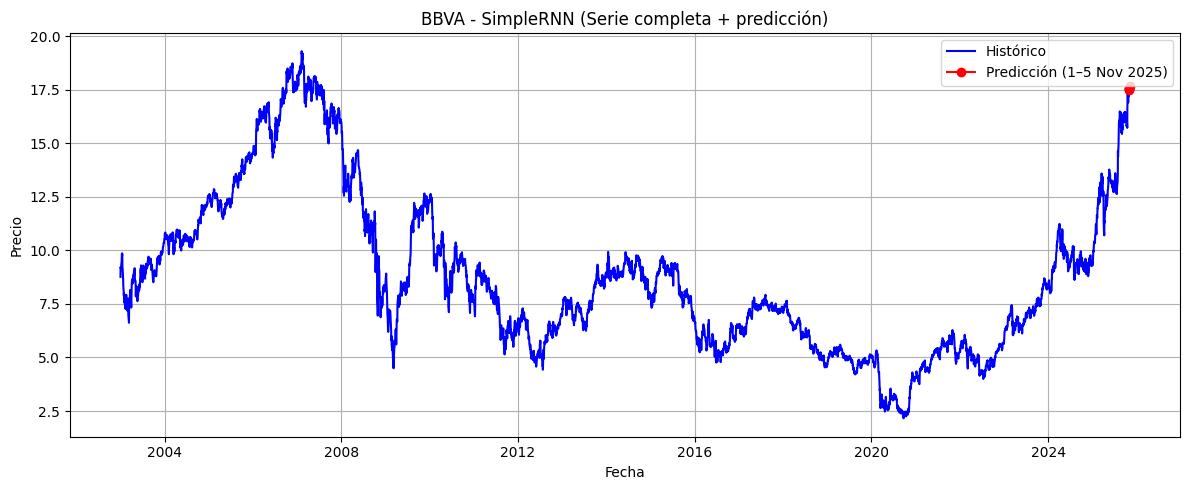

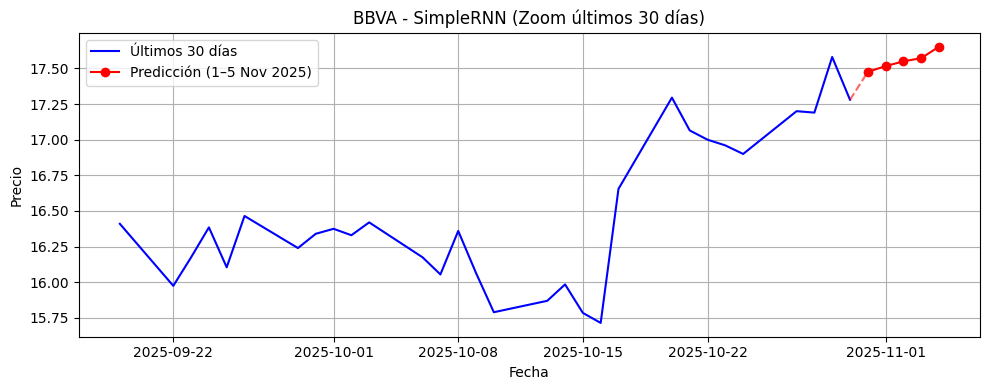

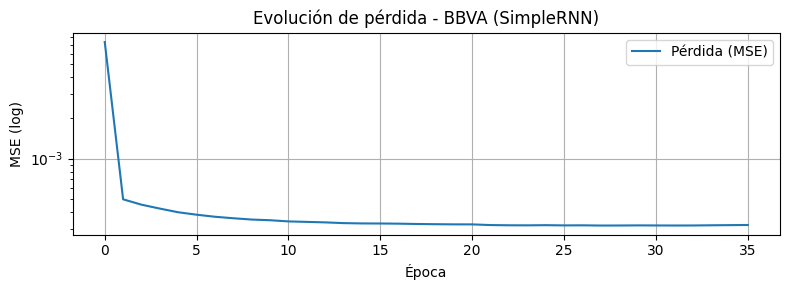


🔹 Entrenando modelo LSTM para BBVA
Epoch 1/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0448

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0128
Epoch 2/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5101e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 7.9128e-04
Epoch 3/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8468e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.5019e-04
Epoch 4/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8975e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.6704e-04
Epoch 5/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3268e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.2872e-04
Epoch 6/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9752e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.8569e-04
Epoch 7/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6991e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.6404e-04
Epoch 8/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5505e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.5291e-04
Epoch 9/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4686e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.3993e-04
Epoch 10/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3168e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.2458e-04
Epoch 11/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1659e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.1143e-04
Epoch 12/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0507e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.0468e-04
Epoch 13/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0230e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.9738e-04
Epoch 14/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9042e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.8887e-04
Epoch 15/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8151e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.8077e-04
Epoch 16/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.7394e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.7301e-04
Epoch 17/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6763e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.6747e-04
Epoch 18/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6224e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.6218e-04
Epoch 19/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5656e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.5775e-04
Epoch 20/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5396e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.5458e-04
Epoch 21/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4989e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.5192e-04
Epoch 22/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4433e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.4623e-04
Epoch 23/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4240e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.4331e-04
Epoch 24/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3706e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.3892e-04
Epoch 25/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3707e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.3790e-04
Epoch 26/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2938e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.3184e-04
Epoch 27/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2766e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.3020e-04
Epoch 28/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2580e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2955e-04
Epoch 29/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2648e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.2738e-04
Epoch 30/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2174e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2363e-04
Epoch 31/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.2474e-04
Epoch 32/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1945e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2125e-04
Epoch 33/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1923e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.2024e-04
Epoch 34/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1836e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1979e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.2047e-04
Epoch 36/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1683e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1851e-04
Epoch 37/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1704e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1830e-04
Epoch 38/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1699e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1771e-04
Epoch 39/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1826e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1784e-04
Epoch 41/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1740e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1764e-04
Epoch 42/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1738e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1709e-04
Epoch 43/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1714e-04
Epoch 44/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1762e-04
Epoch 45/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1782e-04
Epoch 46/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1821e-04
Epoch 47/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1737e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1706e-04
Epoch 48/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1863e-04
Epoch 49/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1870e-04
Epoch 50/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1931e-04
Epoch 51/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1785e-04
Epoch 52/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1779e-04
Epoch 53/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1646e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1705e-04
Epoch 54/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1637e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1696e-04
Epoch 55/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1567e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1614e-04
Epoch 56/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1574e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1608e-04
Epoch 57/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1532e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.1560e-04
Epoch 58/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1512e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1538e-04
Epoch 59/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1493e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1531e-04
Epoch 60/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1533e-04
Epoch 61/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1491e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1499e-04
Epoch 62/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1453e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1469e-04
Epoch 63/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1450e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1437e-04
Epoch 64/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1440e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1409e-04
Epoch 65/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1417e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1396e-04
Epoch 66/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1416e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1371e-04
Epoch 67/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1405e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1362e-04
Epoch 68/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1397e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1349e-04
Epoch 69/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1336e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1290e-04
Epoch 70/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1332e-04
Epoch 71/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1294e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1251e-04
Epoch 72/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1286e-04
Epoch 73/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1336e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1250e-04
Epoch 74/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1313e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1243e-04
Epoch 75/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1306e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1230e-04
Epoch 76/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1244e-04
Epoch 77/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1315e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1214e-04
Epoch 78/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1241e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1192e-04
Epoch 79/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1238e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1138e-04
Epoch 80/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1139e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


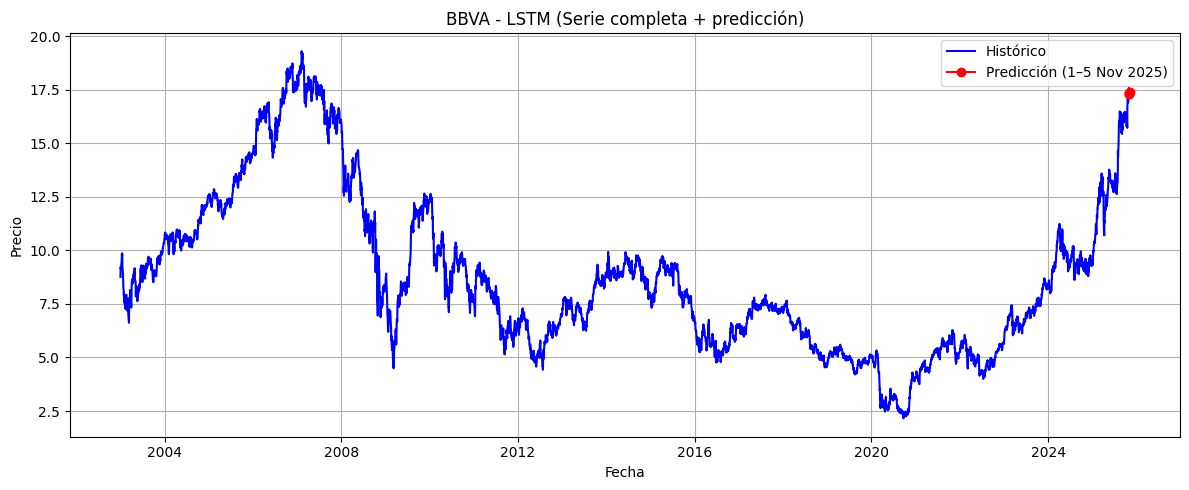

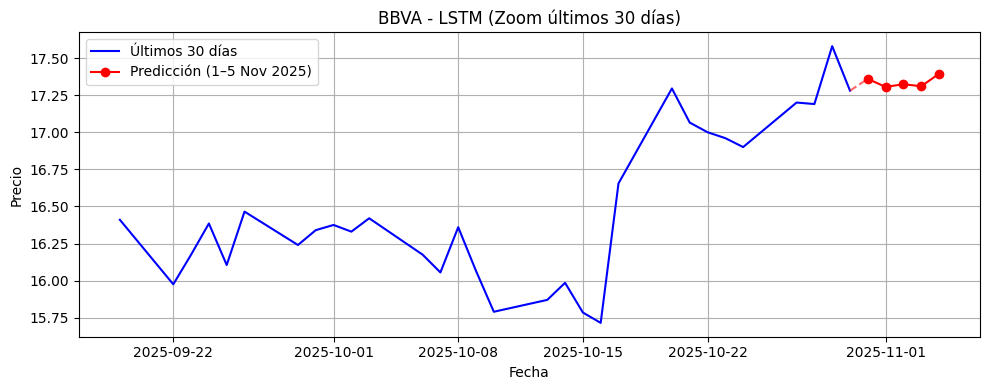

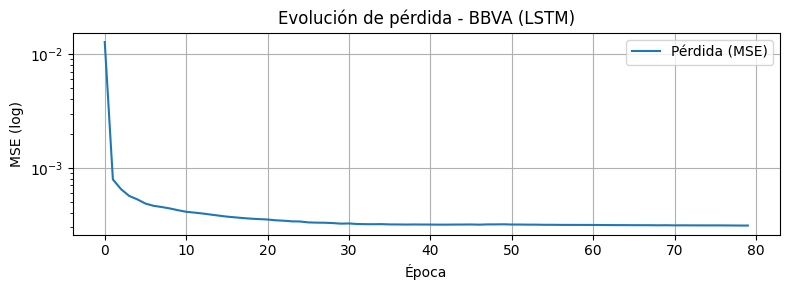


🔹 Entrenando modelo GRU para BBVA
Epoch 1/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0369

181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0104
Epoch 2/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7117e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.6768e-04
Epoch 3/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5948e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.5629e-04
Epoch 4/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5684e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.5233e-04
Epoch 5/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4954e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.4671e-04
Epoch 6/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4533e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.4380e-04
Epoch 7/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.4055e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.3911e-04
Epoch 8/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.3496e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.3594e-04
Epoch 9/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.3188e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.3418e-04
Epoch 10/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2873e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.3267e-04
Epoch 11/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2674e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.2993e-04
Epoch 12/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2377e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2889e-04
Epoch 13/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2436e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.2854e-04
Epoch 14/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.2933e-04
Epoch 15/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2376e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.2721e-04
Epoch 16/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2125e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2448e-04
Epoch 17/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2466e-04
Epoch 18/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1830e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2351e-04
Epoch 19/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2393e-04
Epoch 20/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2385e-04
Epoch 21/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1853e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2131e-04
Epoch 22/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2246e-04
Epoch 23/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1745e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2106e-04
Epoch 24/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2142e-04
Epoch 25/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.2129e-04
Epoch 26/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1686e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.2062e-04
Epoch 27/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1582e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.2037e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1604e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1956e-04
Epoch 29/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1421e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1900e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1961e-04
Epoch 31/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1521e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1845e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1878e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1421e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1795e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1401e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1784e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1398e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1737e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1787e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1419e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1694e-04
Epoch 38/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1367e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1675e-04
Epoch 39/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.1741e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1733e-04
Epoch 41/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1697e-04
Epoch 42/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1694e-04
Epoch 43/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1761e-04
Epoch 44/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.1696e-04
Epoch 45/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1788e-04
Epoch 46/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.1801e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


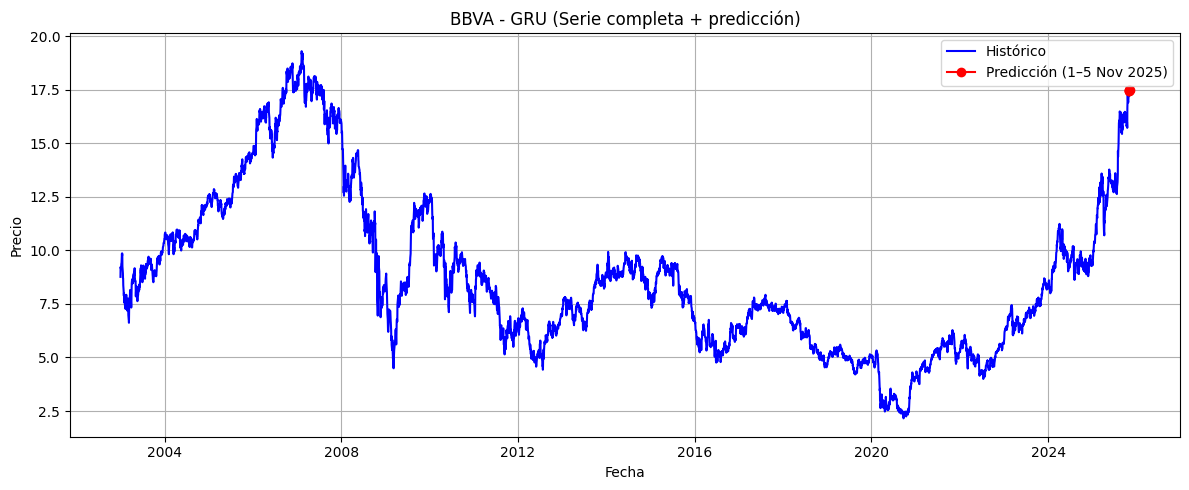

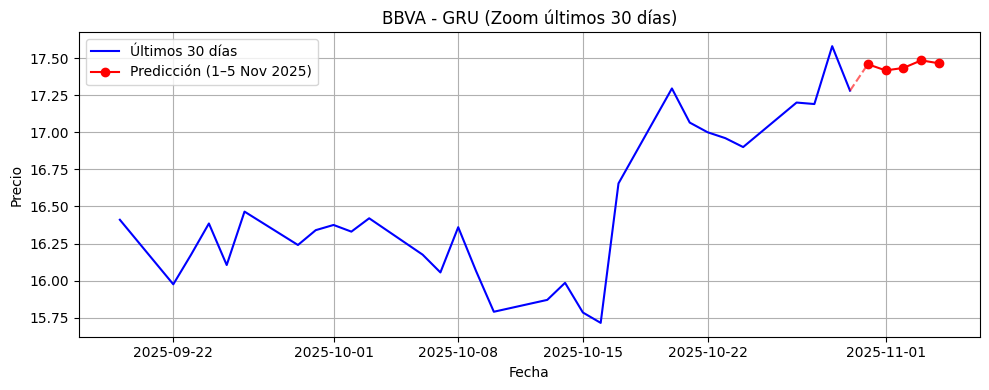

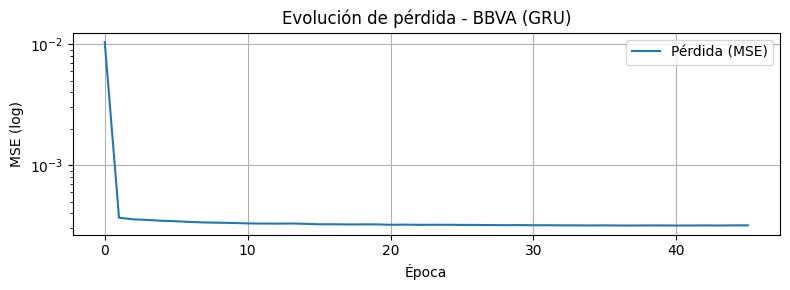


📈 Entrenando modelos para SANTANDER con 5852 registros...

🔹 Entrenando modelo SimpleRNN para SANTANDER
Epoch 1/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0048
Epoch 2/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0755e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0916e-04
Epoch 3/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6518e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.7582e-04
Epoch 4/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3496e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.5238e-04
Epoch 5/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1380e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3428e-04
Epoch 6/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9578e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2088e-04
Epoch 7/80
170/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8721e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0962e-04
Epoch 8/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8368e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0131e-04
Epoch 9/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7710e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9503e-04
Epoch 10/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7441e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9140e-04
Epoch 11/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6946e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8695e-04
Epoch 12/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6829e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8462e-04
Epoch 13/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6641e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8322e-04
Epoch 14/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6482e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8280e-04
Epoch 15/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6437e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8180e-04
Epoch 16/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6376e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8140e-04
Epoch 17/80
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6241e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8017e-04
Epoch 18/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8043e-04
Epoch 19/80
171/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6048e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7971e-04
Epoch 20/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8122e-04
Epoch 21/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8023e-04
Epoch 22/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8011e-04
Epoch 23/80
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5974e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7850e-04
Epoch 24/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6051e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7820e-04
Epoch 25/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7891e-04
Epoch 26/80
170/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5855e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7777e-04
Epoch 27/80
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5801e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7744e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7875e-04
Epoch 29/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5779e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7619e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7848e-04
Epoch 31/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7836e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8017e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7925e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7870e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7915e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7755e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8028e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


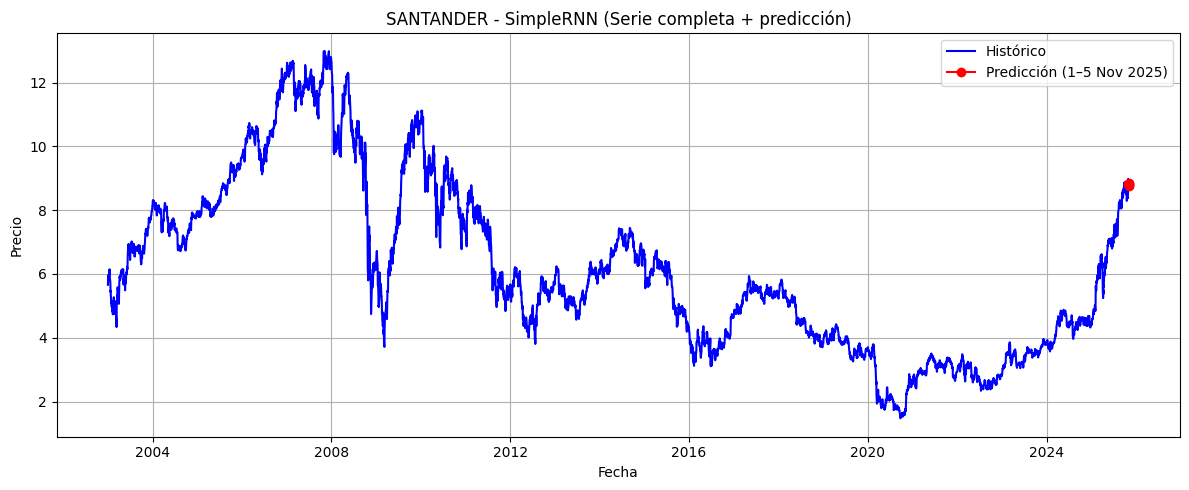

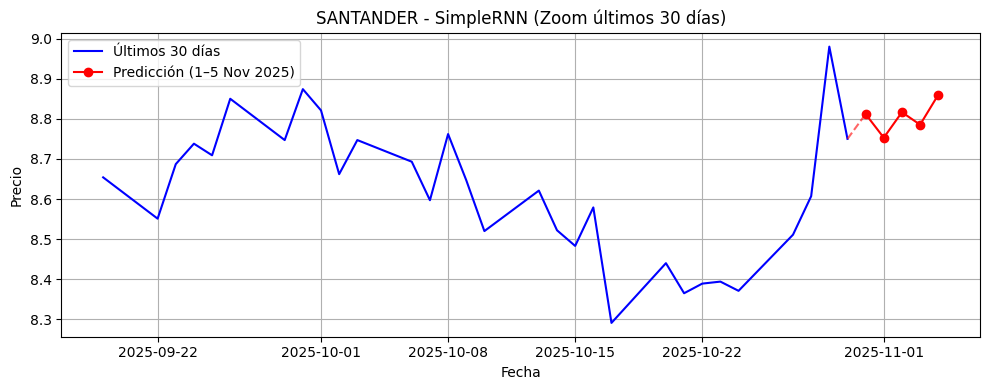

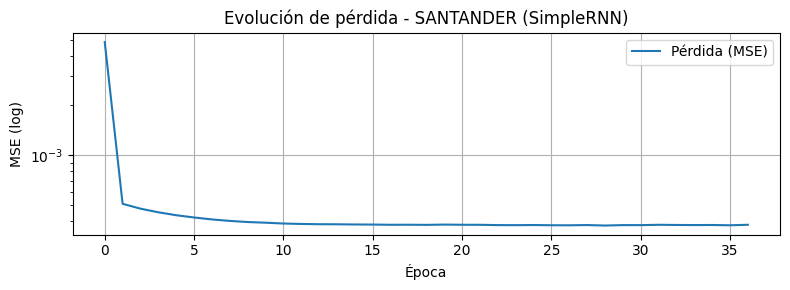


🔹 Entrenando modelo LSTM para SANTANDER
Epoch 1/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0347

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0096
Epoch 2/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2943e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 7.1415e-04
Epoch 3/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5369e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.4002e-04
Epoch 4/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0669e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.9402e-04
Epoch 5/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8025e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.6291e-04
Epoch 6/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4634e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.3427e-04
Epoch 7/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1938e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5.1237e-04
Epoch 8/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9757e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.9306e-04
Epoch 9/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8001e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.7836e-04
Epoch 10/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6363e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.6476e-04
Epoch 11/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5232e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.5569e-04
Epoch 12/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4137e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.4559e-04
Epoch 13/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3107e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.3694e-04
Epoch 14/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2262e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.2988e-04
Epoch 15/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1248e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.2152e-04
Epoch 16/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0742e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.1755e-04
Epoch 17/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0304e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.1324e-04
Epoch 18/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9943e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.1059e-04
Epoch 19/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9632e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.0625e-04
Epoch 20/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9212e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.0290e-04
Epoch 21/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9062e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.0274e-04
Epoch 22/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8401e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.9530e-04
Epoch 23/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.9579e-04
Epoch 24/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8159e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.9372e-04
Epoch 25/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.7983e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.9154e-04
Epoch 26/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.7882e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.9055e-04
Epoch 27/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.7771e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.8966e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7776e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.8921e-04
Epoch 29/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7540e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.8727e-04
Epoch 30/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7294e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8552e-04
Epoch 31/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.8678e-04
Epoch 32/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6861e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8152e-04
Epoch 33/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8303e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8194e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8204e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8179e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8258e-04
Epoch 38/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6860e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8029e-04
Epoch 39/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8158e-04
Epoch 40/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6860e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7941e-04
Epoch 41/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6632e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7810e-04
Epoch 42/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6592e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7742e-04
Epoch 43/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7750e-04
Epoch 44/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6453e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7635e-04
Epoch 45/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6452e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7582e-04
Epoch 46/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6241e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7443e-04
Epoch 47/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7489e-04
Epoch 48/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6211e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.7417e-04
Epoch 49/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7490e-04
Epoch 50/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6120e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7290e-04
Epoch 51/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6029e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7232e-04
Epoch 52/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5980e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7201e-04
Epoch 53/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5861e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7127e-04
Epoch 54/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7234e-04
Epoch 55/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.7136e-04
Epoch 56/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7183e-04
Epoch 57/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5773e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6988e-04
Epoch 58/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7148e-04
Epoch 59/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.7038e-04
Epoch 60/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5711e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6939e-04
Epoch 61/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.7133e-04
Epoch 62/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5643e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6901e-04
Epoch 63/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6971e-04
Epoch 64/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5544e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6833e-04
Epoch 65/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7011e-04
Epoch 66/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6948e-04
Epoch 67/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5373e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.6787e-04
Epoch 68/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6996e-04
Epoch 69/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6822e-04
Epoch 70/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5387e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6694e-04
Epoch 71/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6779e-04
Epoch 72/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5293e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6676e-04
Epoch 73/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6733e-04
Epoch 74/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5290e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6653e-04
Epoch 75/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6718e-04
Epoch 76/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5256e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6651e-04
Epoch 77/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6689e-04
Epoch 78/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6657e-04
Epoch 79/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5068e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6502e-04
Epoch 80/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6551e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


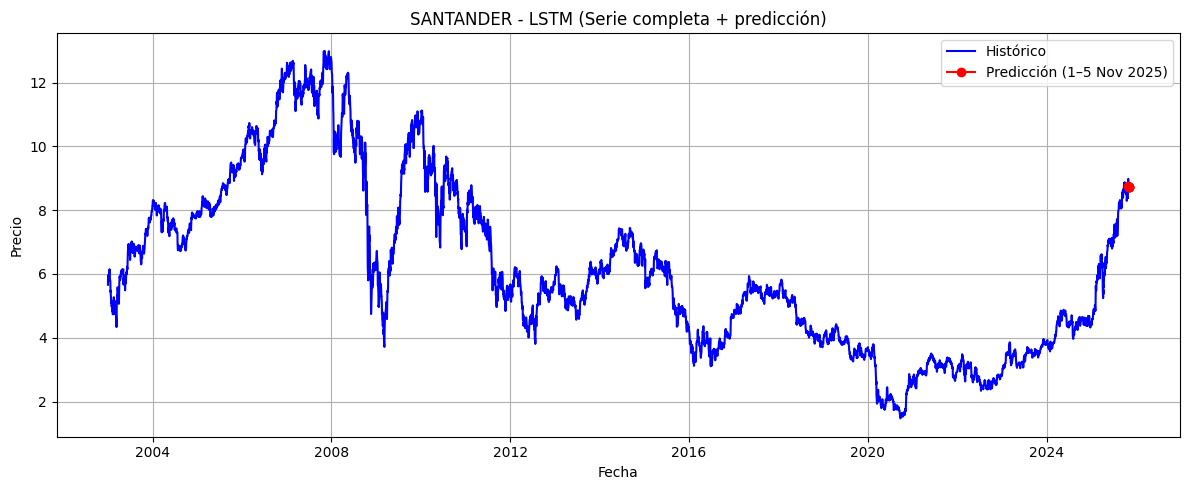

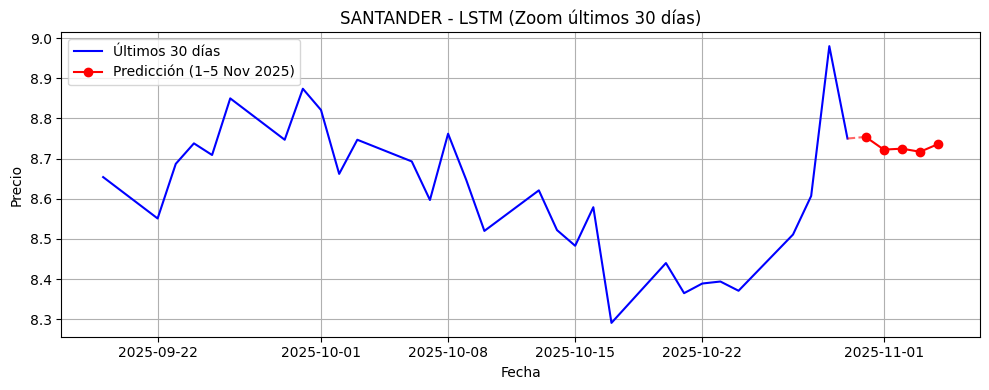

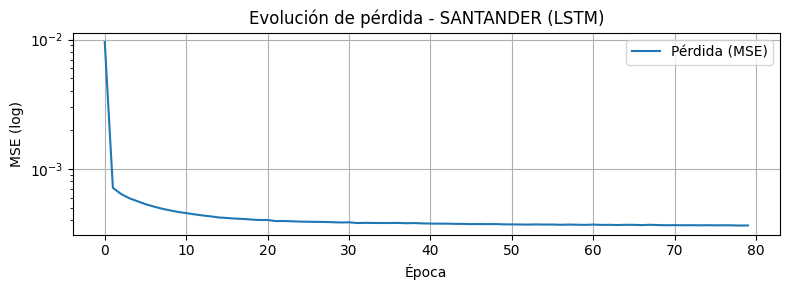


🔹 Entrenando modelo GRU para SANTANDER
Epoch 1/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0606

181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0187
Epoch 2/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7481e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.6975e-04
Epoch 3/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6710e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.6424e-04
Epoch 4/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5018e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.5119e-04
Epoch 5/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3137e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.3688e-04
Epoch 6/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1391e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.2320e-04
Epoch 7/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0650e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.1632e-04
Epoch 8/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9983e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.1157e-04
Epoch 9/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9191e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.0444e-04
Epoch 10/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8962e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.0194e-04
Epoch 11/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8504e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.9892e-04
Epoch 12/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8320e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.9656e-04
Epoch 13/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8012e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.9465e-04
Epoch 14/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7811e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.9239e-04
Epoch 15/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7546e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.9036e-04
Epoch 16/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7459e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8913e-04
Epoch 17/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7240e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8712e-04
Epoch 18/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7182e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8681e-04
Epoch 19/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6944e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8490e-04
Epoch 20/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6980e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8481e-04
Epoch 21/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6752e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8316e-04
Epoch 22/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6692e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8292e-04
Epoch 23/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6467e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8134e-04
Epoch 24/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8176e-04
Epoch 25/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6469e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8115e-04
Epoch 26/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6403e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8052e-04
Epoch 27/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8087e-04
Epoch 28/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6411e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8049e-04
Epoch 29/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6430e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.8038e-04
Epoch 30/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.8177e-04
Epoch 31/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8189e-04
Epoch 32/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8113e-04
Epoch 33/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6454e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7964e-04
Epoch 34/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8079e-04
Epoch 35/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8185e-04
Epoch 36/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8149e-04
Epoch 37/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8160e-04
Epoch 38/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8028e-04
Epoch 39/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8120e-04
Epoch 40/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8077e-04
Epoch 41/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6428e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7917e-04
Epoch 42/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7981e-04
Epoch 43/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8019e-04
Epoch 44/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6342e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7765e-04
Epoch 45/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7832e-04
Epoch 46/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6300e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7762e-04
Epoch 47/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6356e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7759e-04
Epoch 48/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7807e-04
Epoch 49/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6226e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7653e-04
Epoch 50/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6153e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7629e-04
Epoch 51/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7671e-04
Epoch 52/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6112e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.7582e-04
Epoch 53/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7646e-04
Epoch 54/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6232e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7564e-04
Epoch 55/80
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6100e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7481e-04
Epoch 56/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6040e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7461e-04
Epoch 57/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6018e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7431e-04
Epoch 58/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5992e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7370e-04
Epoch 59/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5970e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.7350e-04
Epoch 60/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5896e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7319e-04
Epoch 61/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.7343e-04
Epoch 62/80
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5884e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7288e-04
Epoch 63/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5880e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7263e-04
Epoch 64/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7271e-04
Epoch 65/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5822e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7188e-04
Epoch 66/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5778e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7169e-04
Epoch 67/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7176e-04
Epoch 68/80
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5758e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7116e-04
Epoch 69/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7127e-04
Epoch 70/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5710e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7090e-04
Epoch 71/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5694e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7060e-04
Epoch 72/80
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5668e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7058e-04
Epoch 73/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5716e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7057e-04
Epoch 74/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5646e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.7031e-04
Epoch 75/80
176/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5594e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.7005e-04
Epoch 76/80
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5566e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6939e-04
Epoch 77/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5600e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.6939e-04
Epoch 78/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.6958e-04
Epoch 79/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5580e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6934e-04
Epoch 80/80
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5492e-04

181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.6883e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


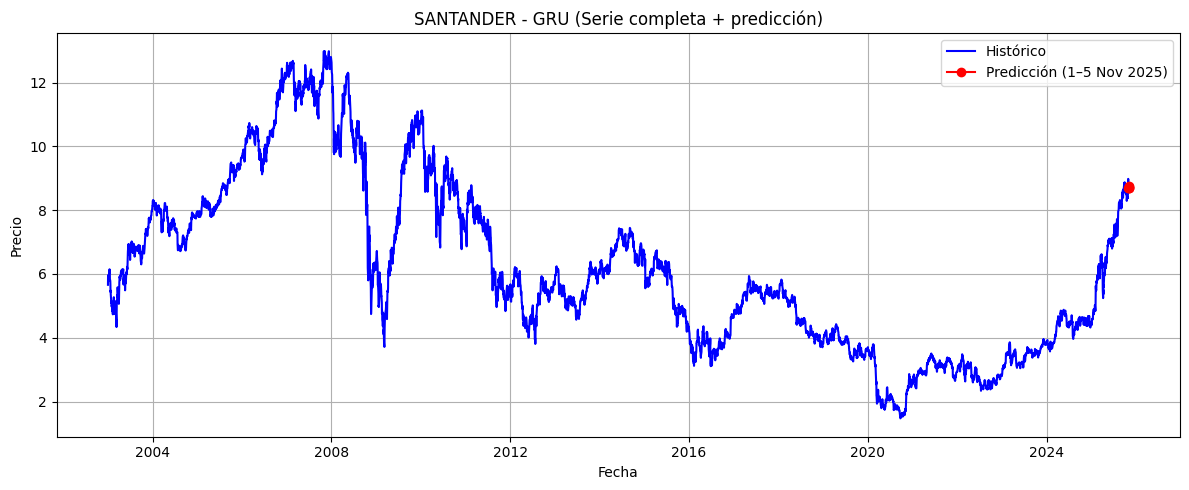

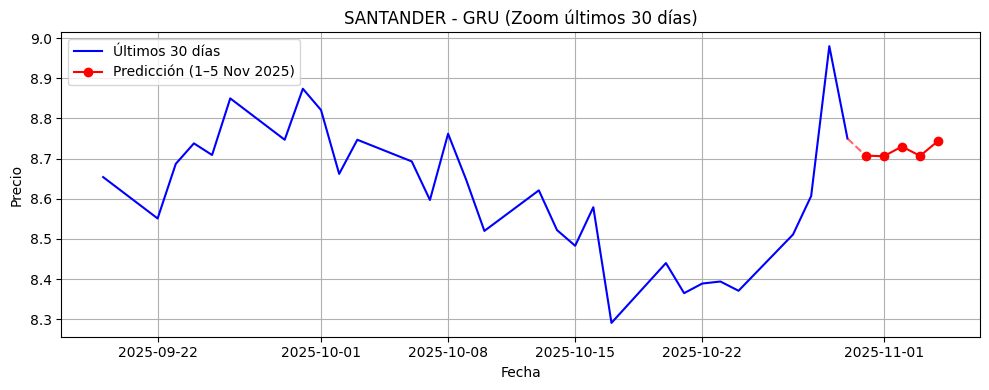

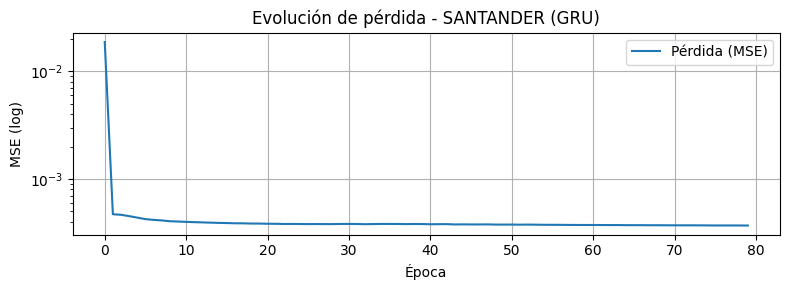


✅ Predicciones completadas. Modelos guardados en: modelos_prediccion_noviembre


In [164]:
# ==========================================
# Predicción multi-step (1–5 Nov 2025)
# ==========================================
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---------- Parámetros ----------
np.random.seed(42)
tf.random.set_seed(42)

timesteps = 60
forecast_days = 5   # 1–5 de noviembre 2025
epochs = 80
batch_size = 32
patience = 8
models_dir = "modelos_prediccion_noviembre"
os.makedirs(models_dir, exist_ok=True)

# ---------- Cargar datos ----------
BBVA_data = pd.read_csv("bbva_completo.csv")
SANTANDER_data = pd.read_csv("santander_completo.csv")

BBVA_data['Date'] = pd.to_datetime(BBVA_data['Date'])
SANTANDER_data['Date'] = pd.to_datetime(SANTANDER_data['Date'])


# ---------- Funciones auxiliares ----------
def create_sequences(series, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(series) - n_steps_in - n_steps_out + 1):
        X.append(series[i:i+n_steps_in])
        y.append(series[i+n_steps_in:i+n_steps_in+n_steps_out])
    X = np.array(X).reshape(-1, n_steps_in, 1)
    y = np.array(y)
    return X, y


def build_rnn(model_type='LSTM', n_steps_in=timesteps, n_steps_out=forecast_days, units=64):
    model = Sequential()
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(units, input_shape=(n_steps_in, 1)))
    elif model_type == 'GRU':
        model.add(GRU(units, input_shape=(n_steps_in, 1)))
    else:
        model.add(LSTM(units, input_shape=(n_steps_in, 1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    return model


def plot_predictions(dates, series, future_dates, pred, stock_name, arch):
    """Crea gráficos profesionalizados para comparar histórico y predicción"""
    # 1️⃣ Histórico completo + predicción
    plt.figure(figsize=(12,5))
    plt.plot(dates, series, label='Histórico', color='blue')
    
    # Conexión entre el último punto real y el primero predicho
    plt.plot([dates[-1], future_dates[0]], [series[-1], pred[0]], 'r--', alpha=0.6)
    
    plt.plot(future_dates, pred, 'ro-', label='Predicción (1–5 Nov 2025)')
    plt.title(f"{stock_name} - {arch} (Serie completa + predicción)")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2️⃣ Últimos 30 días + predicción
    plt.figure(figsize=(10,4))
    plt.plot(dates[-30:], series[-30:], label='Últimos 30 días', color='blue')
    plt.plot([dates[-1], future_dates[0]], [series[-1], pred[0]], 'r--', alpha=0.6)
    plt.plot(future_dates, pred, 'ro-', label='Predicción (1–5 Nov 2025)')
    plt.title(f"{stock_name} - {arch} (Zoom últimos 30 días)")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss(history, stock_name, arch):
    """Gráfico de la función de pérdida"""
    plt.figure(figsize=(8,3))
    plt.plot(history['loss'], label='Pérdida (MSE)')
    plt.yscale('log')
    plt.title(f"Evolución de pérdida - {stock_name} ({arch})")
    plt.xlabel("Época")
    plt.ylabel("MSE (log)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ---------- Entrenamiento + Predicción ----------
def train_and_predict(df_stock, stock_name):
    series = df_stock['Close'].dropna().values.reshape(-1, 1)
    dates = pd.to_datetime(df_stock['Date'].values)

    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    X_train, y_train = create_sequences(series_scaled, timesteps, forecast_days)
    print(f"\n📈 Entrenando modelos para {stock_name} con {len(series)} registros...")

    models = ['SimpleRNN', 'LSTM', 'GRU']
    results = {}

    last_window = series_scaled[-timesteps:].reshape(1, timesteps, 1)

    for arch in models:
        print(f"\n🔹 Entrenando modelo {arch} para {stock_name}")
        model = build_rnn(model_type=arch)
        ckpt_path = os.path.join(models_dir, f"{stock_name}_{arch}_forecast.h5")

        callbacks = [
            EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True),
            ModelCheckpoint(ckpt_path, monitor='loss', save_best_only=True, verbose=0)
        ]

        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=callbacks
        )

        # Predicción futura
        pred_scaled = model.predict(last_window).flatten()
        pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

        # Fechas: 1–5 noviembre 2025
        last_date = dates[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)

        # Guardar resultados
        results[arch] = {
            "model": model,
            "forecast": pred,
            "future_dates": future_dates,
            "ckpt_path": ckpt_path,
            "history": history.history
        }

        # Gráficos
        plot_predictions(dates, series.flatten(), future_dates, pred, stock_name, arch)
        plot_loss(history.history, stock_name, arch)

    return results


# ---------- Ejecutar para ambos bancos ----------
bbva_res = train_and_predict(
    BBVA_data[['Date', 'Close_BBVA.MC']].rename(columns={'Close_BBVA.MC': 'Close'}),
    "BBVA"
)

san_res = train_and_predict(
    SANTANDER_data[['Date', 'Close_SAN.MC']].rename(columns={'Close_SAN.MC': 'Close'}),
    "SANTANDER"
)

print("\n✅ Predicciones completadas. Modelos guardados en:", models_dir)


MAS GRAFICAS IMPORTANTES 

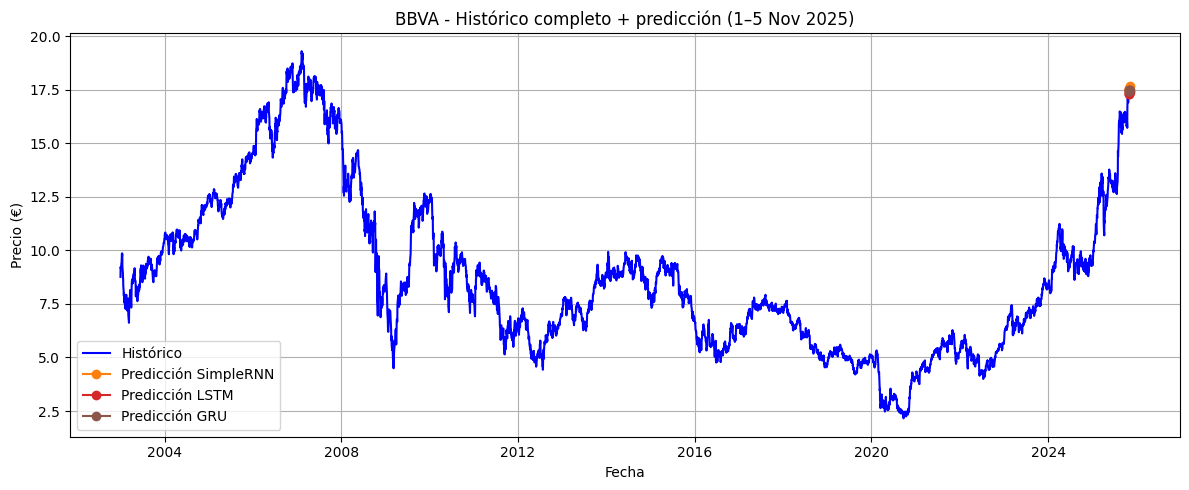

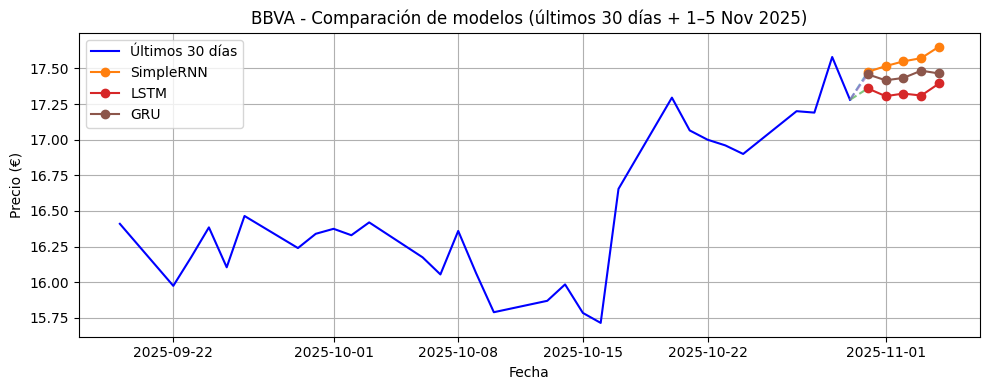

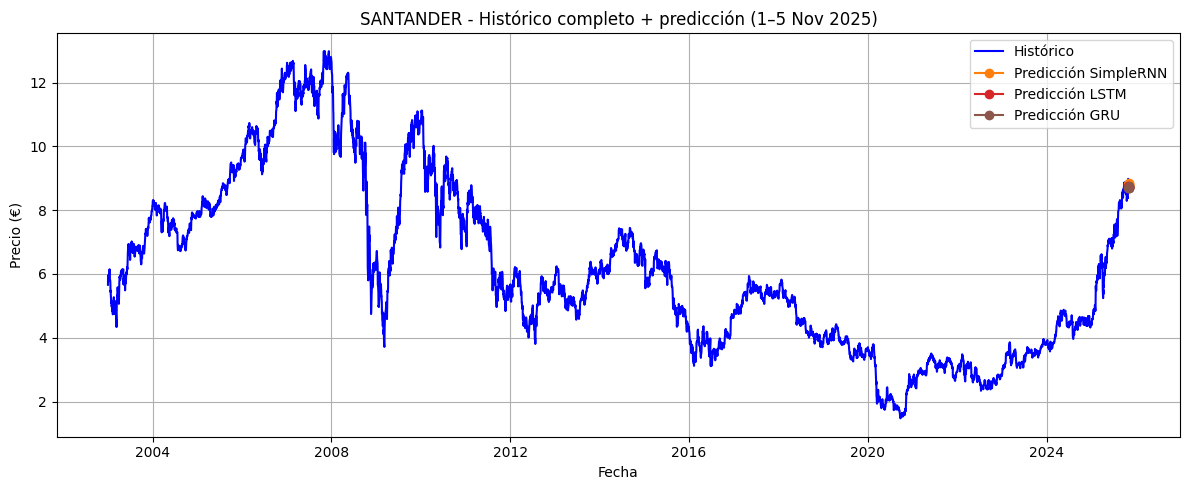

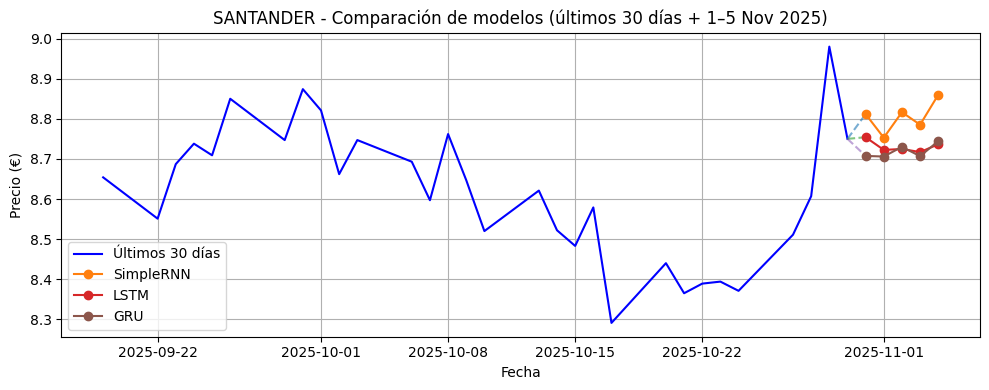

In [165]:
# ==========================================
# Gráficos comparativos posteriores al entrenamiento
# ==========================================

def plot_full_series_with_pred(stock_name, results, original_data):
    """Grafica el histórico completo con la predicción de cada modelo superpuesta"""
    dates = pd.to_datetime(original_data['Date'])
    series = original_data['Close'].values

    plt.figure(figsize=(12,5))
    plt.plot(dates, series, label='Histórico', color='blue')

    for arch, res in results.items():
        future_dates = res['future_dates']
        pred = res['forecast']
        # Conexión visual al último punto real
        plt.plot([dates.iloc[-1], future_dates[0]], [series[-1], pred[0]], '--', alpha=0.6)
        plt.plot(future_dates, pred, 'o-', label=f'Predicción {arch}')

    plt.title(f"{stock_name} - Histórico completo + predicción (1–5 Nov 2025)")
    plt.xlabel("Fecha")
    plt.ylabel("Precio (€)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_last30_comparison(stock_name, results, original_data):
    """Grafica los últimos 30 días con las 3 predicciones comparadas"""
    dates = pd.to_datetime(original_data['Date'])
    series = original_data['Close'].values

    plt.figure(figsize=(10,4))
    plt.plot(dates[-30:], series[-30:], label='Últimos 30 días', color='blue')

    for arch, res in results.items():
        future_dates = res['future_dates']
        pred = res['forecast']
        plt.plot([dates.iloc[-1], future_dates[0]], [series[-1], pred[0]], '--', alpha=0.6)
        plt.plot(future_dates, pred, 'o-', label=f'{arch}')

    plt.title(f"{stock_name} - Comparación de modelos (últimos 30 días + 1–5 Nov 2025)")
    plt.xlabel("Fecha")
    plt.ylabel("Precio (€)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ==========================================
# Ejecutar para BBVA y SANTANDER
# ==========================================

# --- BBVA ---
plot_full_series_with_pred(
    "BBVA",
    bbva_res,
    BBVA_data[['Date', 'Close_BBVA.MC']].rename(columns={'Close_BBVA.MC': 'Close'})
)

plot_last30_comparison(
    "BBVA",
    bbva_res,
    BBVA_data[['Date', 'Close_BBVA.MC']].rename(columns={'Close_BBVA.MC': 'Close'})
)

# --- SANTANDER ---
plot_full_series_with_pred(
    "SANTANDER",
    san_res,
    SANTANDER_data[['Date', 'Close_SAN.MC']].rename(columns={'Close_SAN.MC': 'Close'})
)

plot_last30_comparison(
    "SANTANDER",
    san_res,
    SANTANDER_data[['Date', 'Close_SAN.MC']].rename(columns={'Close_SAN.MC': 'Close'})
)


Univariado autoregresivo (GRU recursivo, predict-one-step & roll-forward)

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def plot_full_historic_prediction(stock_name, results, original_data, timesteps=60, forecast_days=5):
    """
    Genera predicciones completas desde el inicio del dataset hasta 5 días más allá del final.
    Dibuja el histórico y las series predichas por cada modelo.
    """
    dates = pd.to_datetime(original_data['Date']).reset_index(drop=True)
    series = original_data['Close'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    for arch, res in results.items():
        model = res["model"]

        # ---- Generar predicciones sobre toda la serie (rolling forecast) ----
        preds_scaled = []
        for i in range(timesteps, len(series_scaled)):
            window = series_scaled[i - timesteps:i].reshape(1, timesteps, 1)
            pred_scaled = model.predict(window, verbose=0)[0][0]  # primer valor de salida
            preds_scaled.append(pred_scaled)

        preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
        pred_dates = dates[timesteps:]

        # ---- Predicción futura (5 días) ----
        last_window = series_scaled[-timesteps:].reshape(1, timesteps, 1)
        future_scaled = model.predict(last_window, verbose=0).flatten()
        future_pred = scaler.inverse_transform(future_scaled.reshape(-1, 1)).flatten()
        future_dates = pd.date_range(start=dates.iloc[-1] + pd.Timedelta(days=1), periods=forecast_days)

        # ---- Gráfico completo ----
        plt.figure(figsize=(14,6))
        plt.plot(dates, series, label='Histórico real', color='blue', alpha=0.6)
        plt.plot(pred_dates, preds, color='red', label=f'Predicción {arch} (rolling)')
        plt.plot(future_dates, future_pred, 'ro--', label='Predicción futura (1–5 Nov 2025)')

        # 🔧 Corregimos el tramo de conexión
        x_conn = [pd.Timestamp(dates.iloc[-1]), pd.Timestamp(future_dates[0])]
        y_conn = [float(series[-1]), float(future_pred[0])]
        plt.plot(x_conn, y_conn, 'r--', alpha=0.6)

        plt.title(f"{stock_name} - {arch} (Predicción completa desde 2000 + futuro)")
        plt.xlabel("Fecha")
        plt.ylabel("Precio (€)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


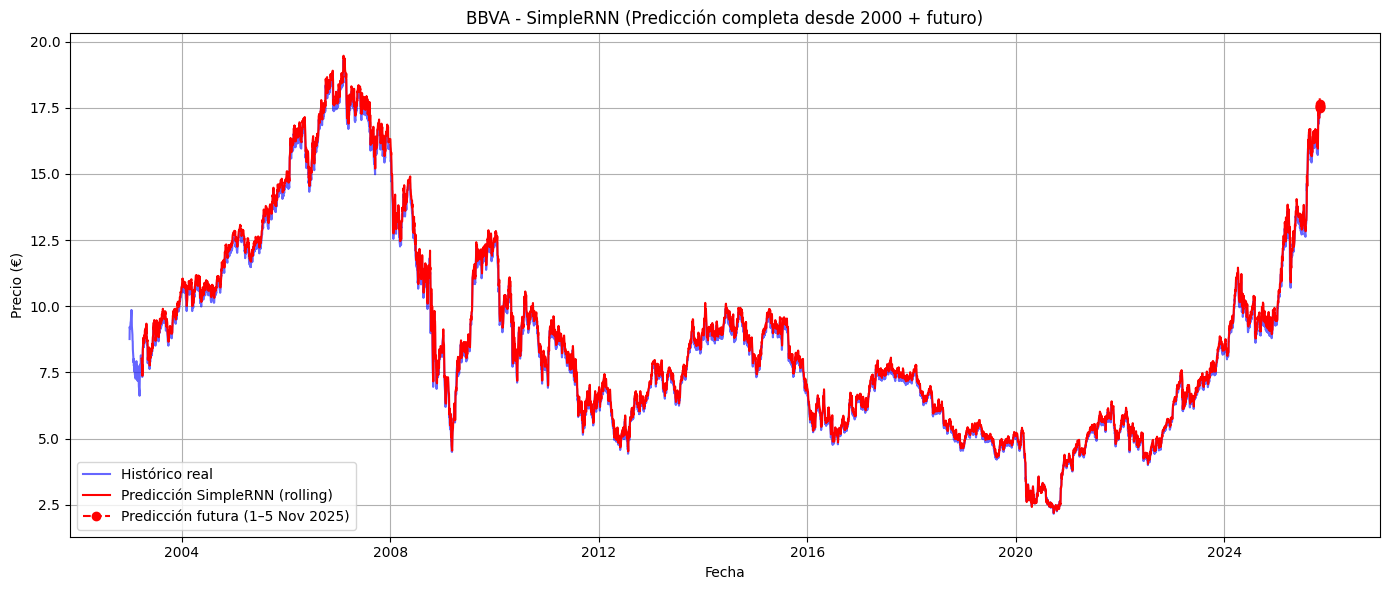

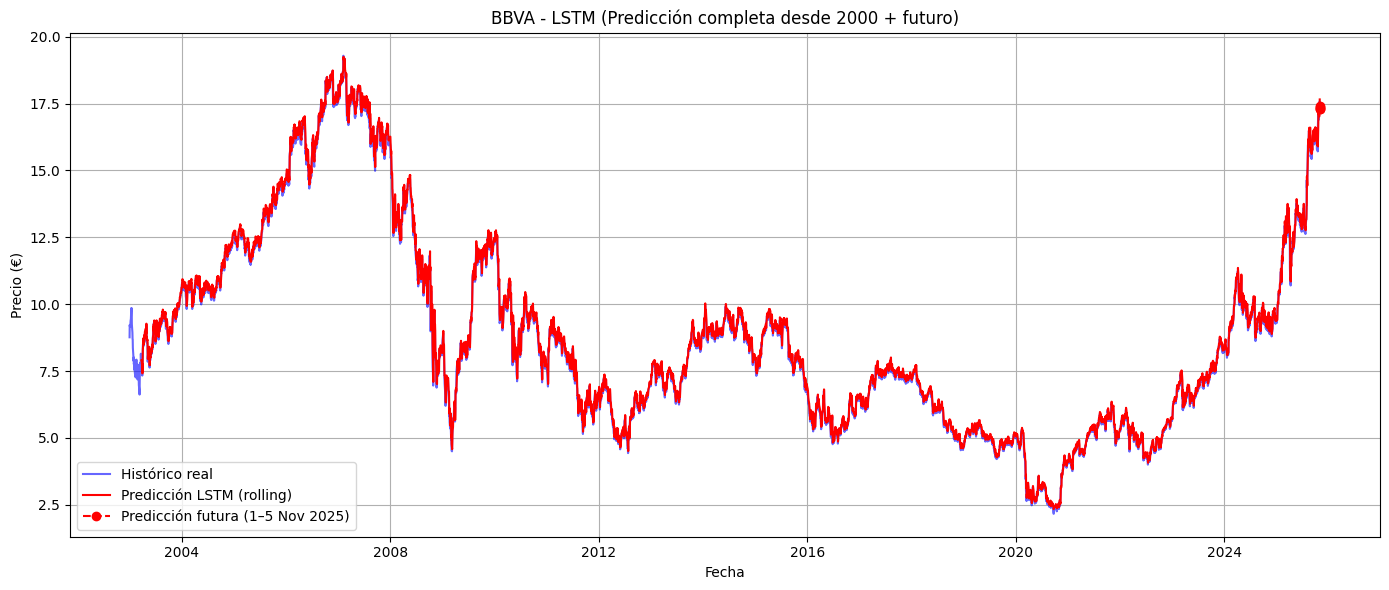

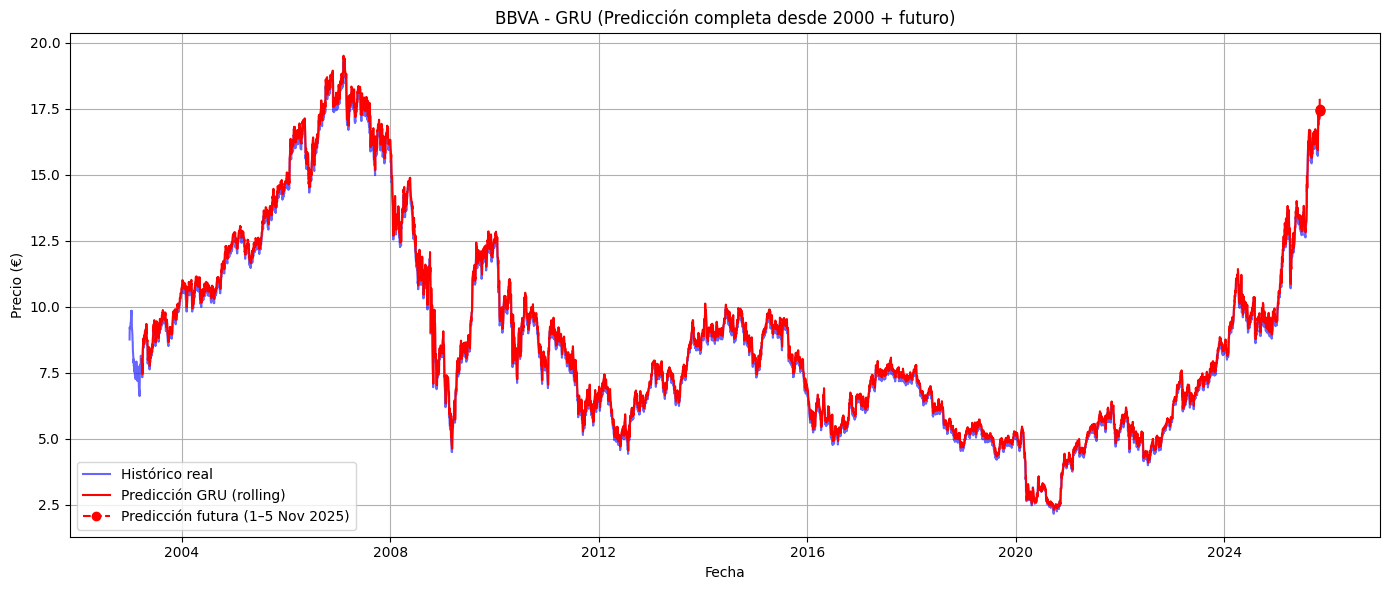

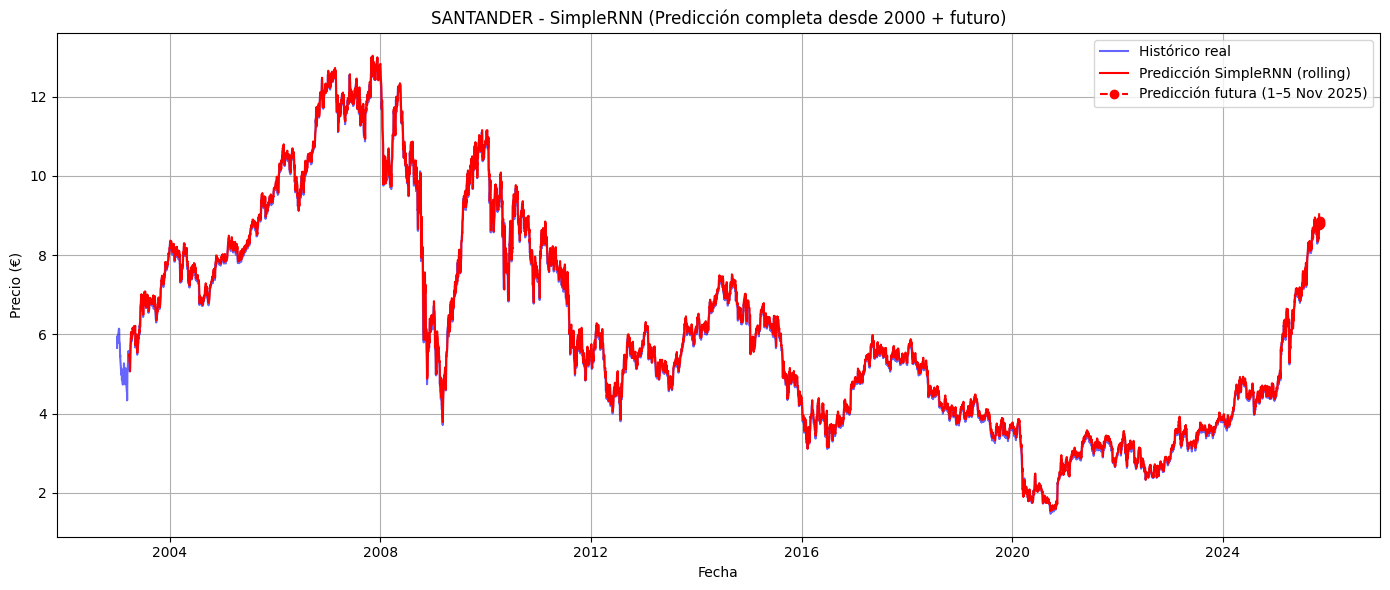

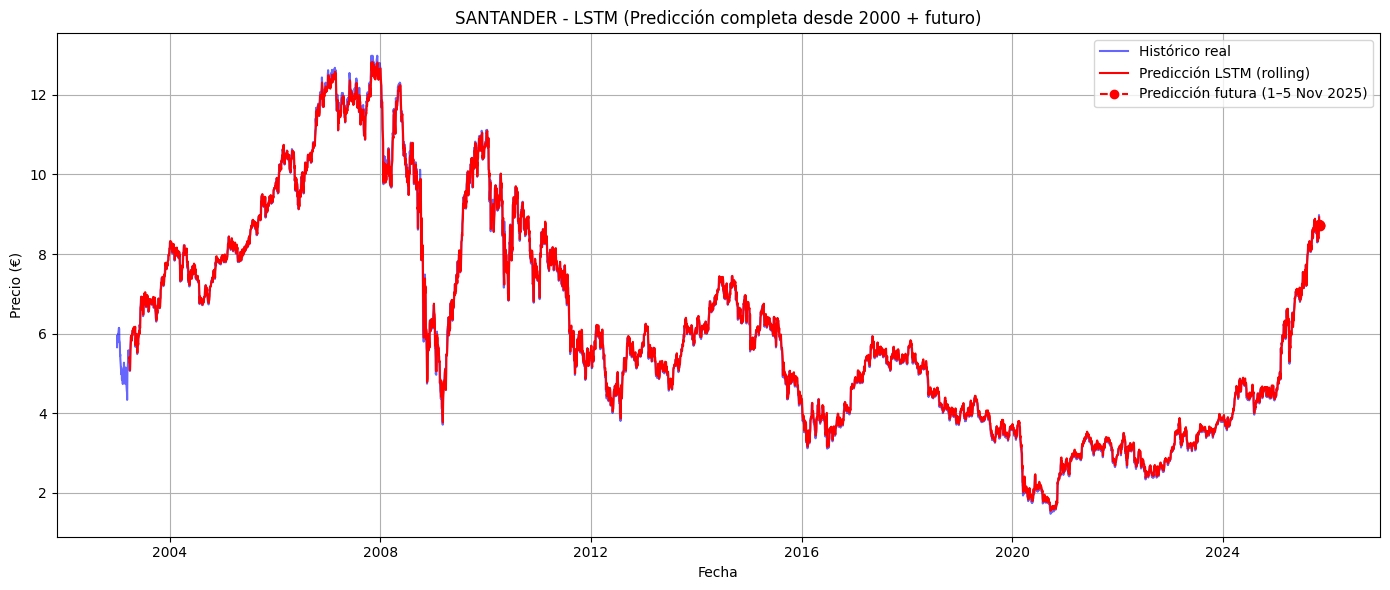

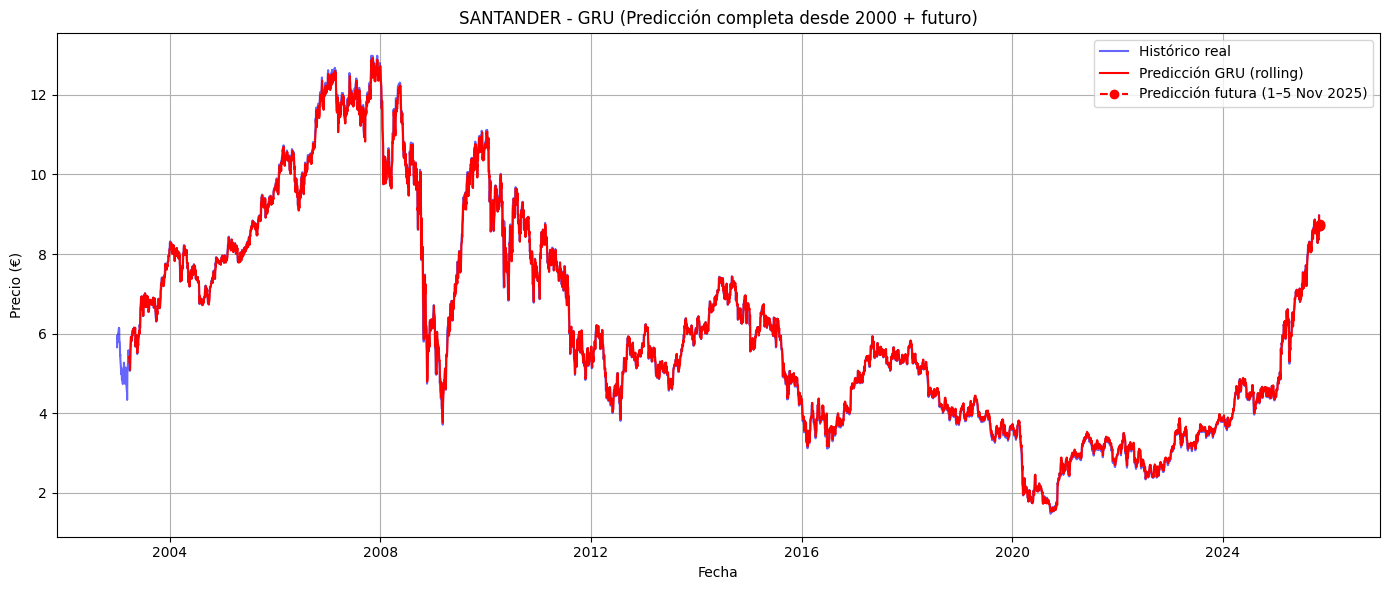

In [173]:
# --- BBVA ---
plot_full_historic_prediction(
    "BBVA",
    bbva_res,
    BBVA_data[['Date', 'Close_BBVA.MC']].rename(columns={'Close_BBVA.MC': 'Close'})
)

# --- SANTANDER ---
plot_full_historic_prediction(
    "SANTANDER",
    san_res,
    SANTANDER_data[['Date', 'Close_SAN.MC']].rename(columns={'Close_SAN.MC': 'Close'})
)


In [174]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def plot_last_30days_prediction(stock_name, results, original_data, timesteps=60, forecast_days=5):
    """
    Genera la predicción y gráfico solo para los últimos 30 días del histórico.
    Muestra el histórico real + rolling prediction + predicción futura.
    """
    dates = pd.to_datetime(original_data['Date']).reset_index(drop=True)
    series = original_data['Close'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    for arch, res in results.items():
        model = res["model"]

        # ---- Rolling predictions sobre toda la serie ----
        preds_scaled = []
        for i in range(timesteps, len(series_scaled)):
            window = series_scaled[i - timesteps:i].reshape(1, timesteps, 1)
            pred_scaled = model.predict(window, verbose=0)[0][0]
            preds_scaled.append(pred_scaled)

        preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
        pred_dates = dates[timesteps:]

        # ---- Predicción futura (5 días) ----
        last_window = series_scaled[-timesteps:].reshape(1, timesteps, 1)
        future_scaled = model.predict(last_window, verbose=0).flatten()
        future_pred = scaler.inverse_transform(future_scaled.reshape(-1, 1)).flatten()
        future_dates = pd.date_range(start=dates.iloc[-1] + pd.Timedelta(days=1), periods=forecast_days)

        # ---- Filtrar últimos 30 días ----
        last_30_cutoff = dates.iloc[-30]
        mask_real = dates >= last_30_cutoff
        mask_pred = pred_dates >= last_30_cutoff

        dates_30 = dates[mask_real]
        series_30 = series[mask_real]
        pred_dates_30 = pred_dates[mask_pred]
        preds_30 = preds[-len(pred_dates_30):]

        # ---- Gráfico ----
        plt.figure(figsize=(14,6))
        plt.plot(dates_30, series_30, label='Histórico (últimos 30 días)', color='blue', alpha=0.7)
        plt.plot(pred_dates_30, preds_30, 'r-', label=f'Predicción {arch} (rolling)')
        plt.plot(future_dates, future_pred, 'ro--', label='Predicción futura (1–5 Nov 2025)')

        # Línea de conexión con el futuro
        x_conn = [pd.Timestamp(dates.iloc[-1]), pd.Timestamp(future_dates[0])]
        y_conn = [float(series[-1]), float(future_pred[0])]
        plt.plot(x_conn, y_conn, 'r--', alpha=0.6)

        plt.title(f"{stock_name} - {arch} (Últimos 30 días + predicción futura)")
        plt.xlabel("Fecha")
        plt.ylabel("Precio (€)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


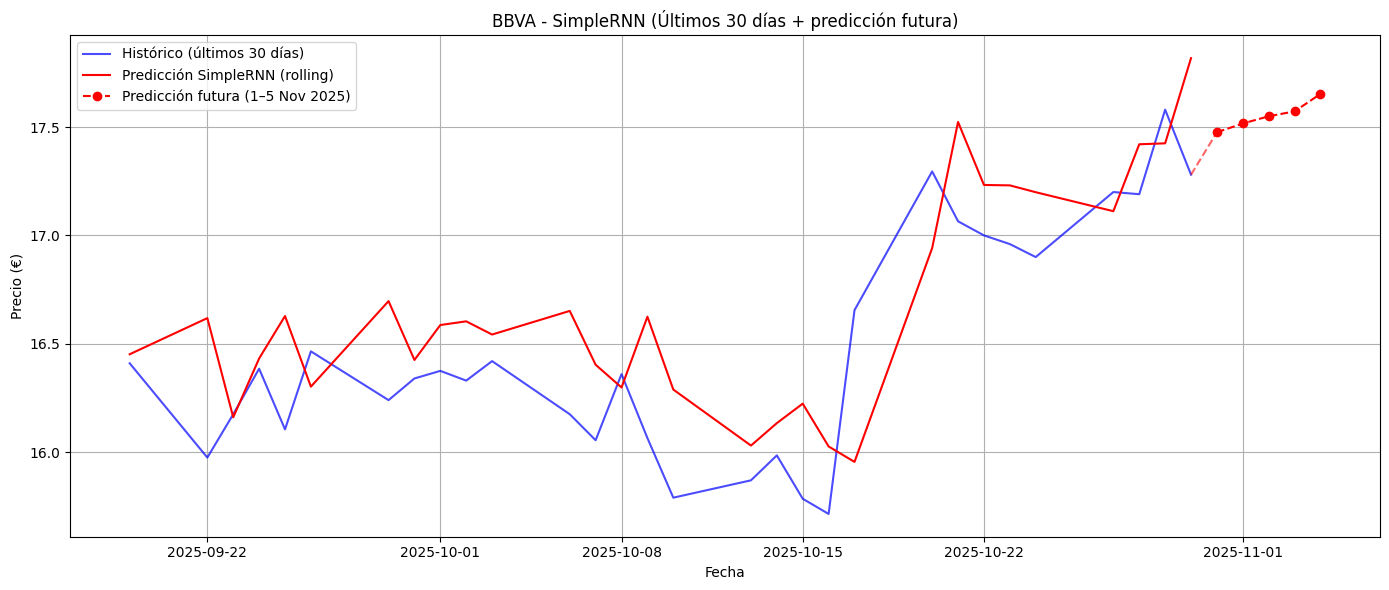

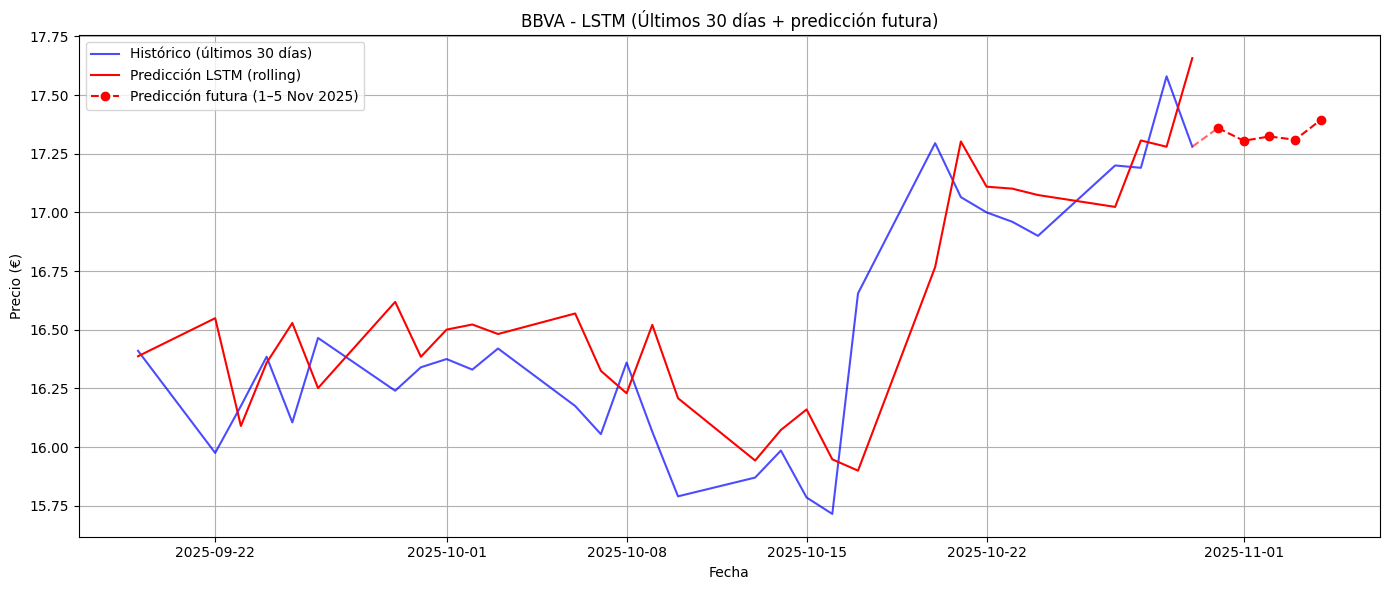

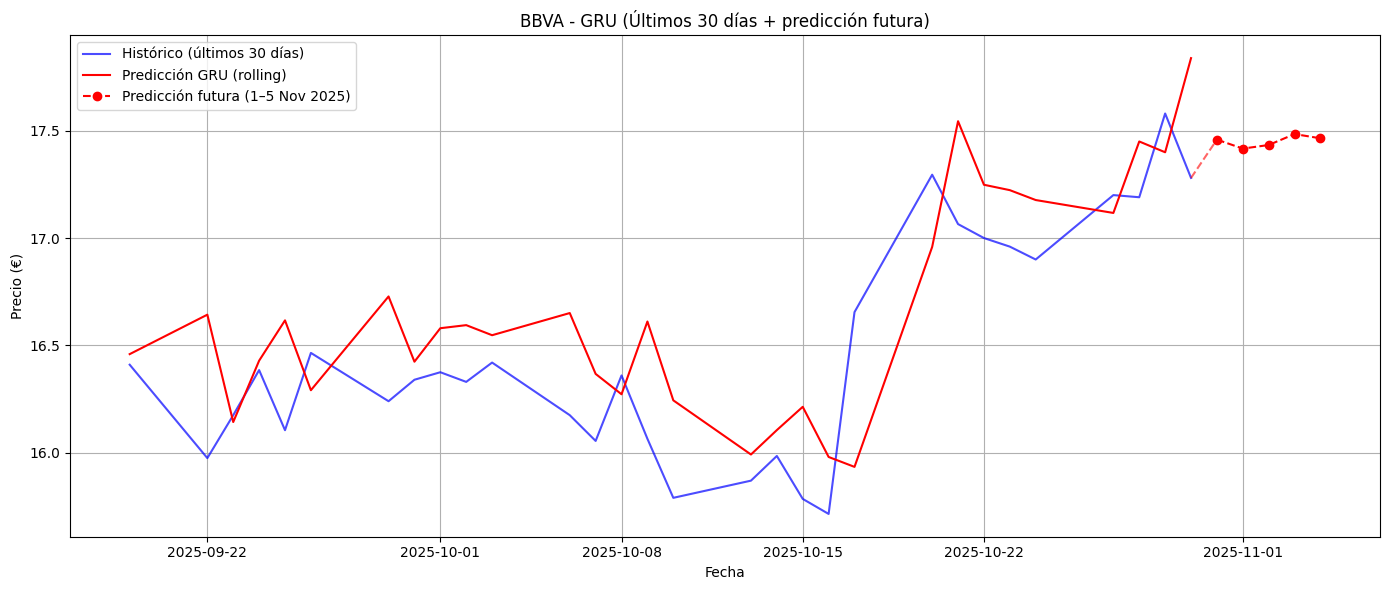

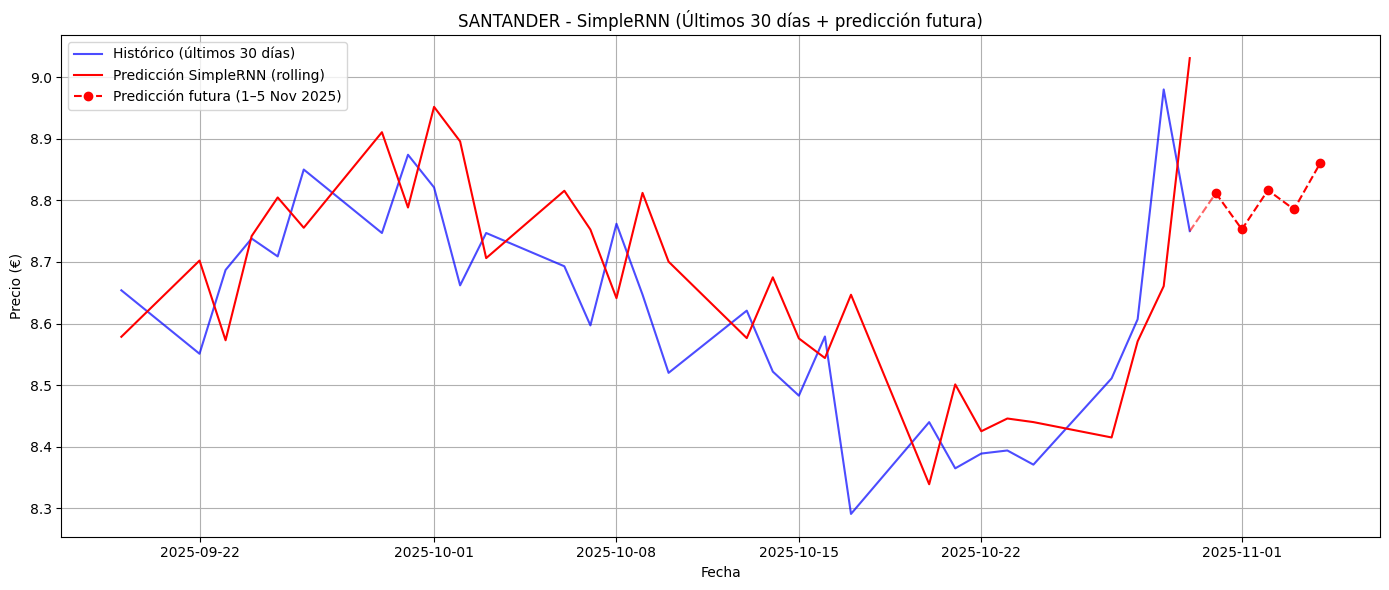

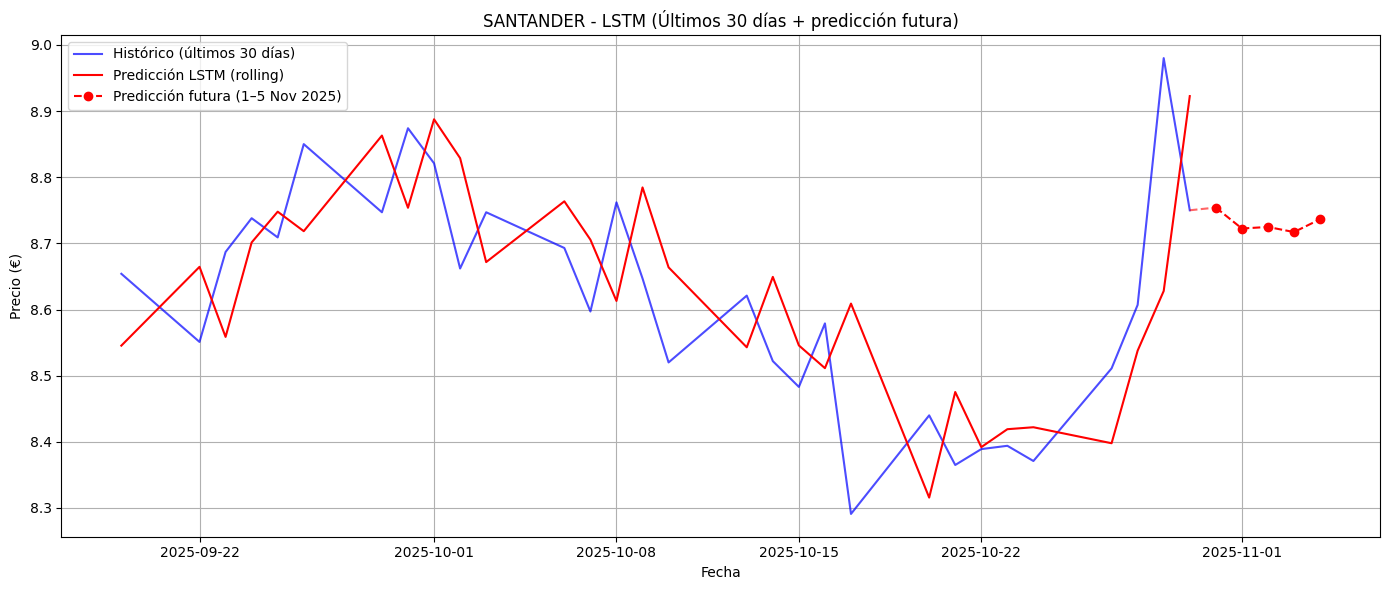

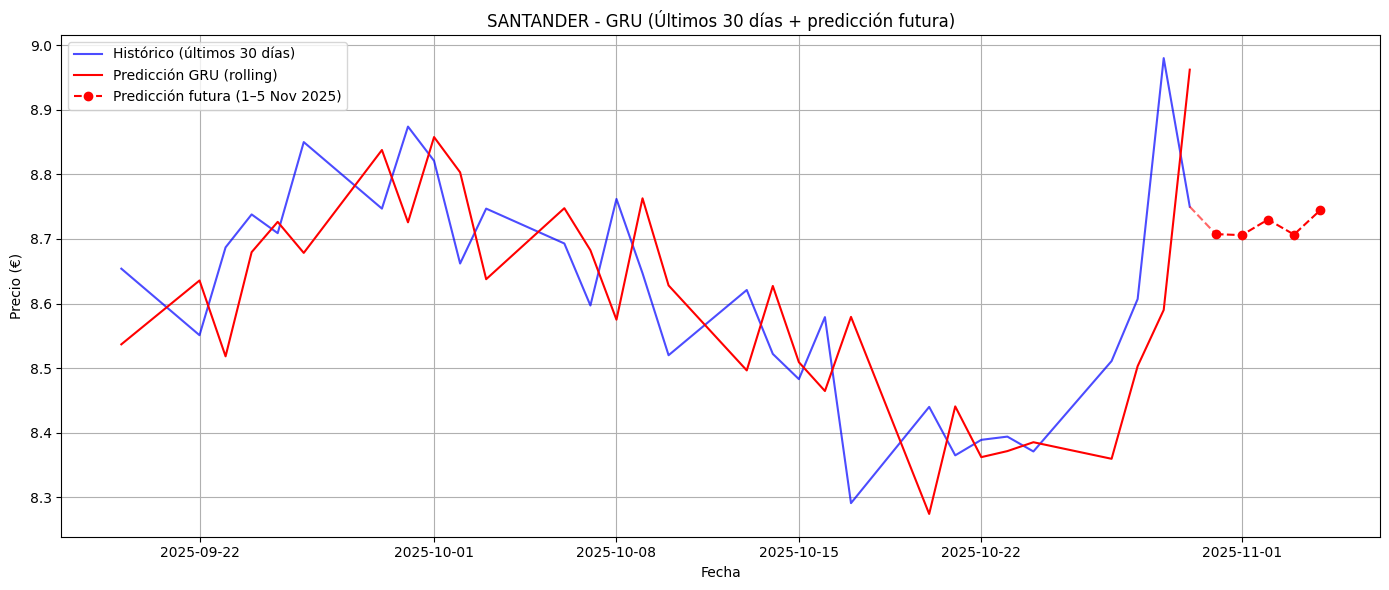

In [175]:
# --- BBVA ---
plot_last_30days_prediction(
    "BBVA",
    bbva_res,
    BBVA_data[['Date', 'Close_BBVA.MC']].rename(columns={'Close_BBVA.MC': 'Close'})
)

# --- SANTANDER ---
plot_last_30days_prediction(
    "SANTANDER",
    san_res,
    SANTANDER_data[['Date', 'Close_SAN.MC']].rename(columns={'Close_SAN.MC': 'Close'})
)



LSTM optimizado con validación y reducción de ruido (diferenciación logarítmica)

Epoch 1/120
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0379

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0120 - val_loss: 0.0023
Epoch 2/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 3/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 4/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 5/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 6/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 7/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 8/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 9/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 10/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0033

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 11/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0033

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 12/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 13/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 14/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 15/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 16/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 17/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 18/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 19/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 20/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 21/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0032

163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 22/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 23/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 24/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 25/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 26/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 27/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 28/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 29/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 30/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 31/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0033 - val_loss: 0.0022
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/

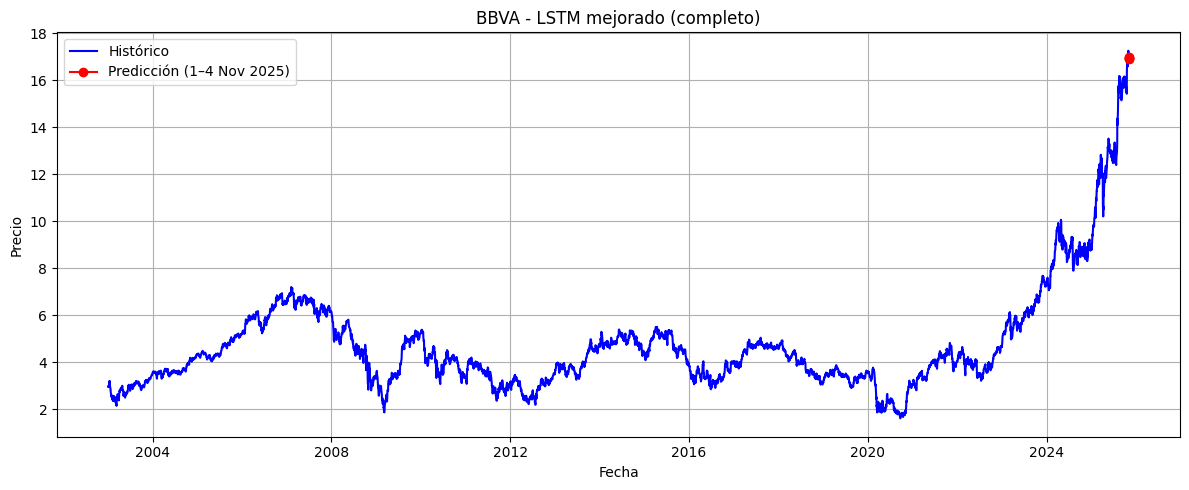

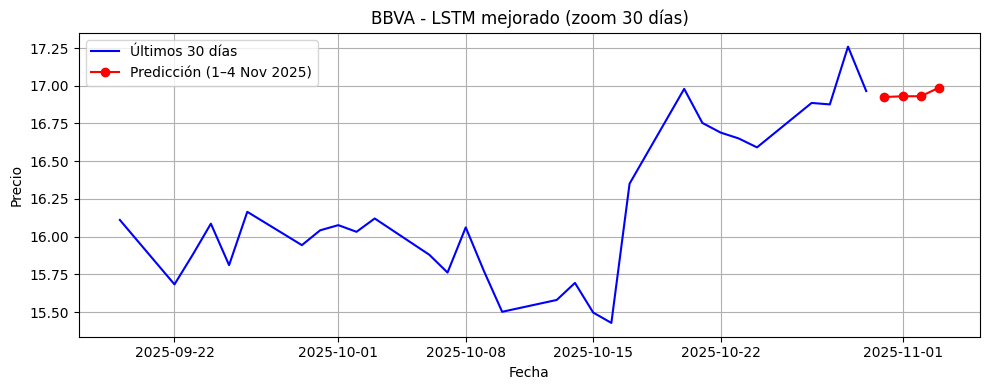

Epoch 1/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0388

163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0116 - val_loss: 0.0017
Epoch 2/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 3/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 4/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 6/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 7/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 8/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 9/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 10/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 11/120
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0026 - val_loss: 0.0018
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


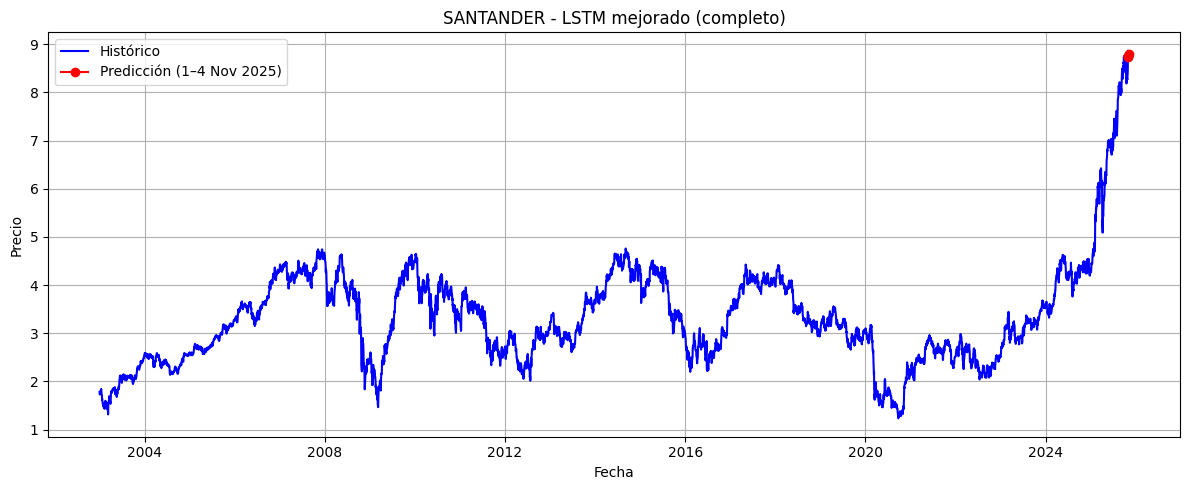

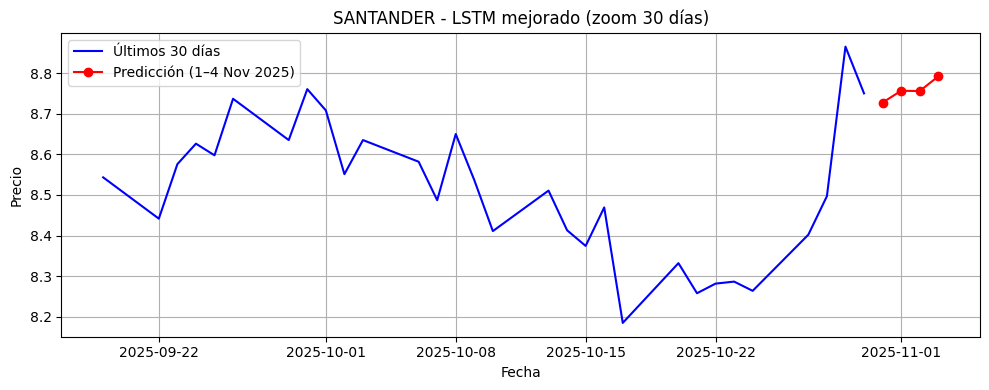


✅ Predicción completada con LSTM mejorado.


In [ ]:
# -------------------------------------------
# LSTM mejorado con log-retornos + validación
# -------------------------------------------
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---------- parámetros ----------
timesteps = 60
forecast_days = 4
epochs = 120
batch_size = 32
patience = 10
models_dir = "modelos_LSTM_mejorado"
os.makedirs(models_dir, exist_ok=True)

# ---------- cargar datos ----------
BBVA_data = pd.read_csv("bbva_completo.csv")
SANTANDER_data = pd.read_csv("santander_completo.csv")
for df in [BBVA_data, SANTANDER_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# ---------- utilidades ----------
def create_sequences(series, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(series) - n_steps_in - n_steps_out + 1):
        X.append(series[i:i+n_steps_in])
        y.append(series[i+n_steps_in:i+n_steps_in+n_steps_out])
    X = np.array(X).reshape(-1, n_steps_in, 1)
    y = np.array(y)
    return X, y

def build_lstm(n_steps_in, n_steps_out):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(n_steps_in, 1)),
        Dropout(0.2),
        LSTM(50),
        Dense(64, activation='relu'),
        Dense(n_steps_out)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_and_predict(df_stock, stock_name):
    df = df_stock.copy()
    df['Close'] = df['Close'].astype(float)
    df = df.dropna()
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df = df.dropna().reset_index(drop=True)

    series = df['Return'].values.reshape(-1, 1)
    dates = pd.to_datetime(df['Date'].values)

    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    X, y = create_sequences(series_scaled, timesteps, forecast_days)
    n_train = int(0.9 * len(X))

    model = build_lstm(timesteps, forecast_days)
    ckpt_path = os.path.join(models_dir, f"{stock_name}_LSTM_mejorado.h5")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=0)
    ]

    model.fit(
        X[:n_train], y[:n_train],
        validation_data=(X[n_train:], y[n_train:]),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=callbacks
    )

    last_window = series_scaled[-timesteps:].reshape(1, timesteps, 1)
    pred_scaled = model.predict(last_window).flatten()
    pred_returns = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

    # Reconstruimos los precios a partir del último valor
    last_close = df['Close'].iloc[-1]
    pred_prices = [last_close * np.exp(sum(pred_returns[:i+1])) for i in range(forecast_days)]

    future_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days)

    # Gráfico completo
    plt.figure(figsize=(12,5))
    plt.plot(dates, df['Close'], label='Histórico', color='blue')
    plt.plot(future_dates, pred_prices, 'ro-', label='Predicción (1–4 Nov 2025)')
    plt.title(f"{stock_name} - LSTM mejorado (completo)")
    plt.xlabel("Fecha"); plt.ylabel("Precio"); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    # Gráfico últimos 30 días
    plt.figure(figsize=(10,4))
    plt.plot(dates[-30:], df['Close'].iloc[-30:], label='Últimos 30 días', color='blue')
    plt.plot(future_dates, pred_prices, 'ro-', label='Predicción (1–4 Nov 2025)')
    plt.title(f"{stock_name} - LSTM mejorado (zoom 30 días)")
    plt.xlabel("Fecha"); plt.ylabel("Precio"); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    return pred_prices

# ---------- Ejecutar ----------
bbva_pred = train_and_predict(BBVA_data[['Date', 'Close_BBVA.MC']].rename(columns={'Close_BBVA.MC': 'Close'}), "BBVA")
san_pred  = train_and_predict(SANTANDER_data[['Date', 'Close_SAN.MC']].rename(columns={'Close_SAN.MC': 'Close'}), "SANTANDER")

print("\n✅ Predicción completada con LSTM mejorado.")
